# Analysing the data and the results

## Contents

1. Analyse data
   1. Load dataset
   2. Inspect type of dataset
   3. Analyse dataset
   4. Preprocess dataset
2. Machine learning pipeline
   1. Define different model architectures
   2. Utils: training loop and computing performance
   3. Define different model instances and train them all
   4. Analysis of the evolution of the training and validation losses for each model
   5. Analysis of the confusion matrix of each model on the validation dataset
   6. Model Selection
   7. Model evaluation
3. Analyse Results
   1. Plot confusion matrix
   2. Plot examples of misclassified inputs
   3. Final comments

**Objectives:**

1. Practice even more what you have learned with the tutorials and the previous assigments.
2. Encourage critical thinking when analysing data and results

Of course, in reality, more sanity checks could be implemented and the analysis could go much deeper. Don't hesitate to also check the `project_checklist` document. What you should always keep in mind though is that **you should never just trust the numbers! Nor blindly use tools that you don't understand**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import Counter

SEED = 265
torch.manual_seed(SEED)

## 1. Analyse data

### 1.1 Load dataset

The dataset is an image classification dataset.

#### Tasks

1. Download the datasets from the link given in the MittUiB assignment and load it using torch.load().
2. Split the `train_val` dataset into a training and a validation dataset.

In [2]:
data_train_val = torch.load("data_train_val.pt")
data_train, data_val = random_split(
        data_train_val, 
        [0.9, 0.1],
        generator=torch.Generator().manual_seed(SEED)
    )

data_test = torch.load("data_test.pt")

### 1.2 Inspect type of dataset

#### Tasks

Inspect the dataset. Do everything that seems relevant to you to have a better idea of the type of data you will play with. You can for example try to answer the following questions first:

- What is the size of each dataset?
- What is the shape of the input?
- What is the type of the input tensors?
- What is the shape of the targets?
- What is the type of the target tensors?
- How many classes are there?
- What do instances of each class look like?

Remember that you can acces any element of a dataset without using any dataloader using `data[i]`. 

See `02 - Machine learning pipeline and MNIST` for more information about plotting instances for each class

In [3]:
# Extract one image and one label from the dataset
img, label = data_train[0]

print('Size of the dataset      : %d' %len(data_train))
print('Shape of the input       :', img.shape)
print('Type of the input        :', img.dtype)
print('Shape of the target      :', label.shape)
print('Type of the target       :', label.dtype)

Size of the dataset      : 94222
Shape of the input       : torch.Size([1, 28, 28])
Type of the input        : torch.float32
Shape of the target      : torch.Size([])
Type of the target       : torch.int64


Label:  0


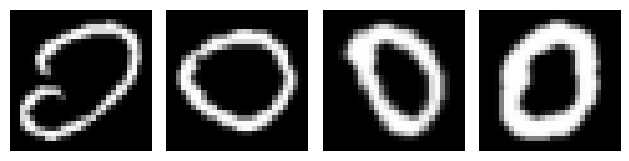

Label:  1


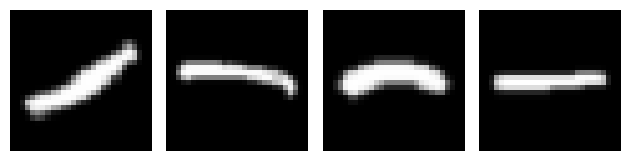

Label:  2


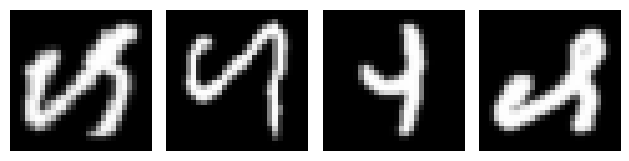

Label:  3


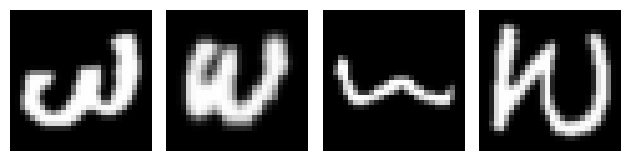

Label:  4


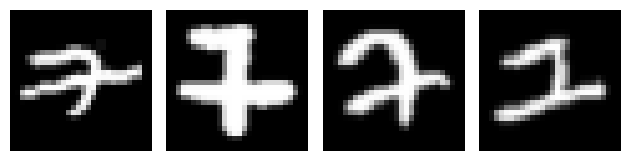

Label:  5


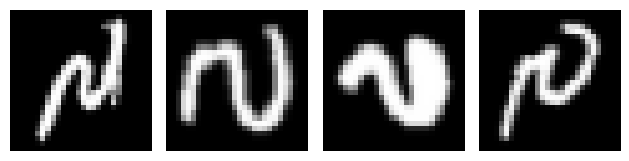

Label:  6


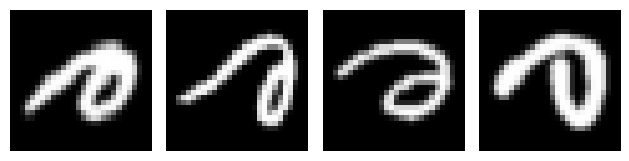

Label:  7


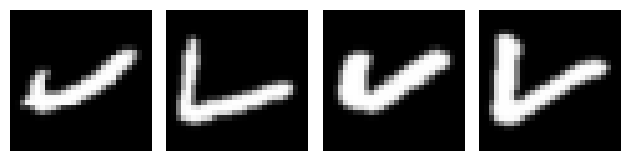

Label:  8


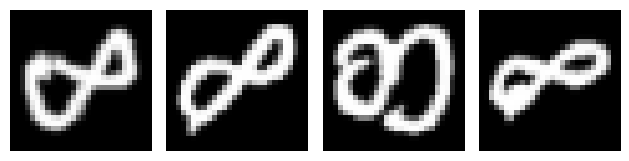

Label:  9


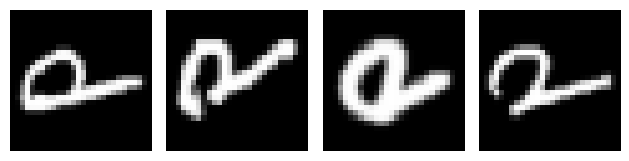

Label:  10


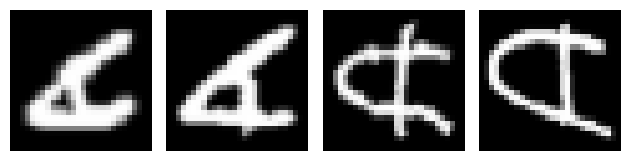

Label:  11


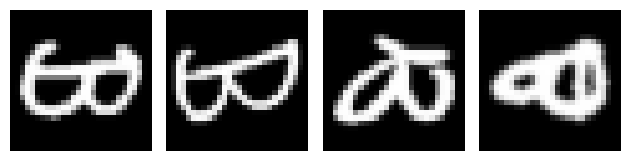

Label:  12


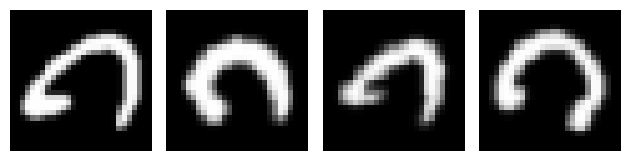

Label:  13


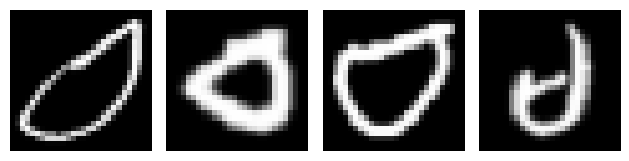

Label:  14


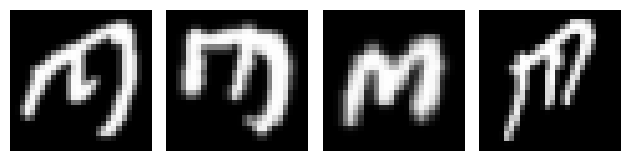

Label:  15


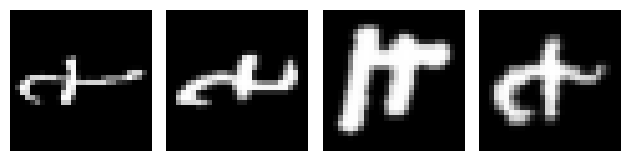

Label:  16


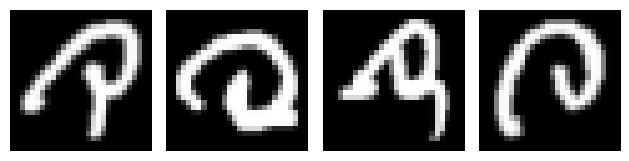

Label:  17


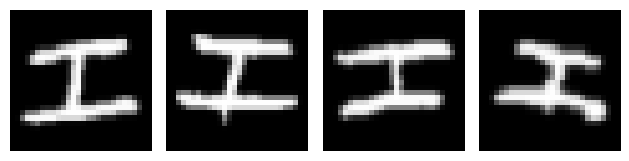

Label:  18


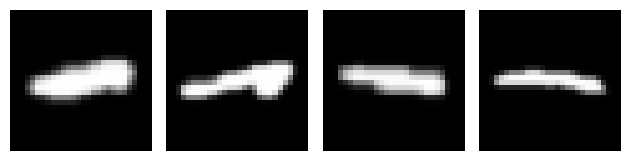

Label:  19


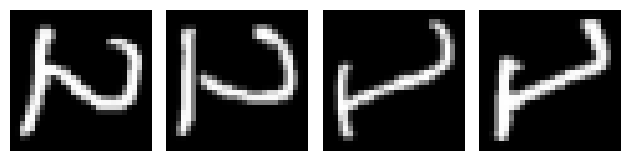

Label:  20


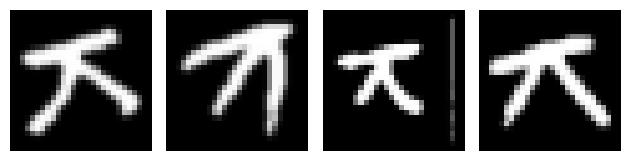

Label:  21


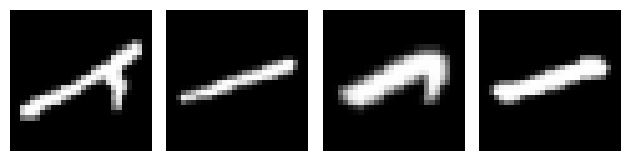

Label:  22


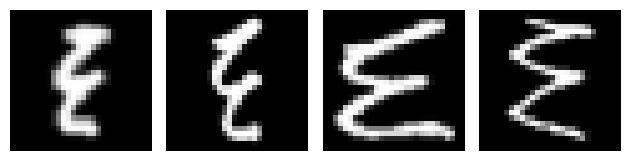

Label:  23


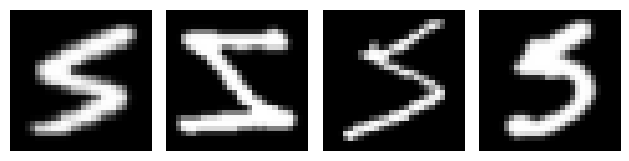

Label:  24


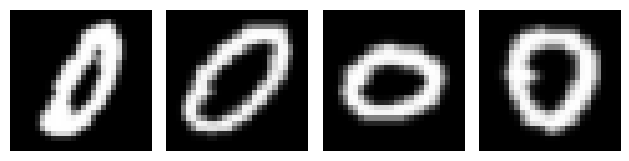

Label:  25


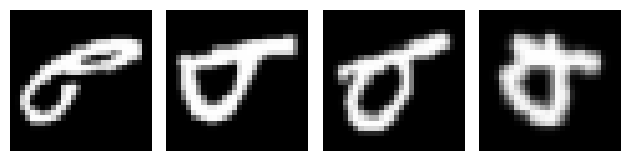

Label:  26


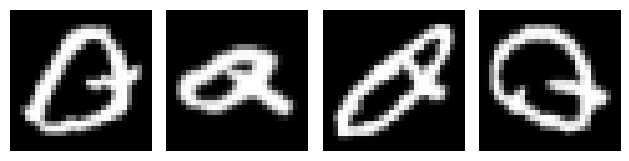

Label:  27


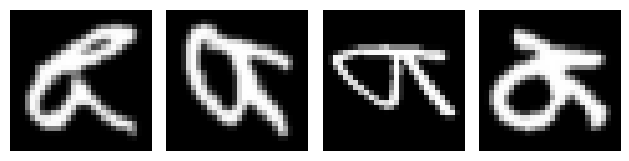

Label:  28


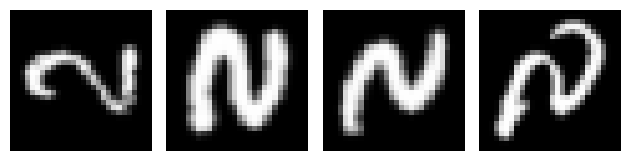

Label:  29


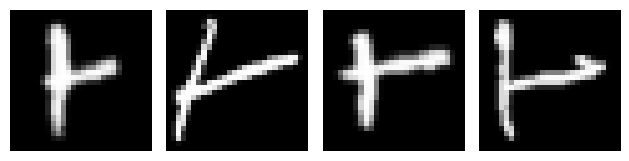

Label:  30


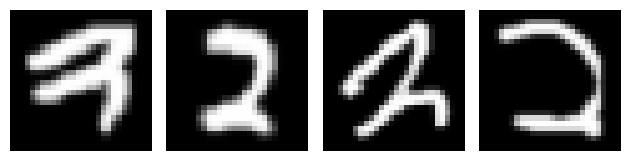

Label:  31


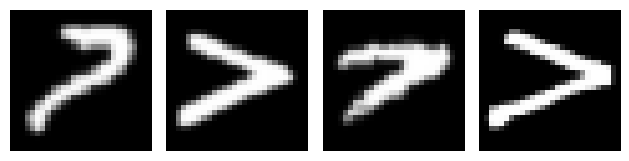

Label:  32


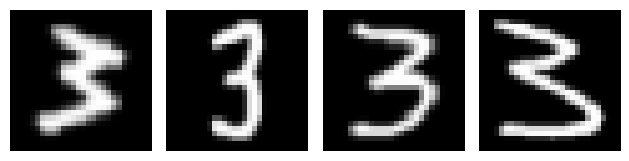

Label:  33


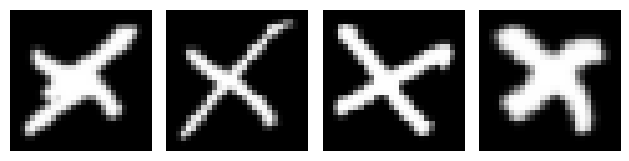

Label:  34


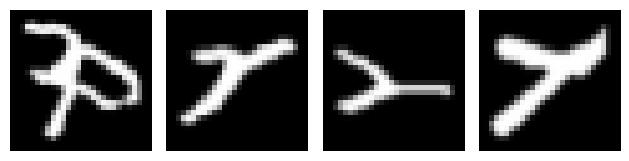

Label:  35


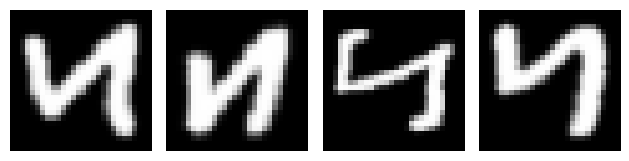

Label:  36


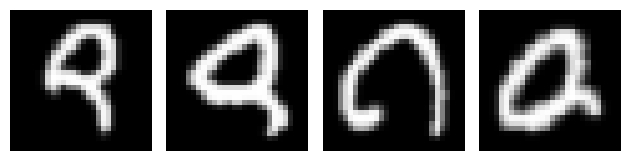

Label:  37


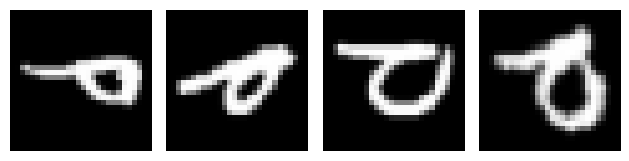

Label:  38


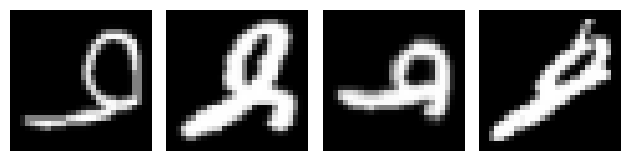

Label:  39


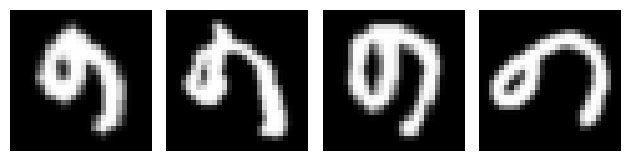

Label:  40


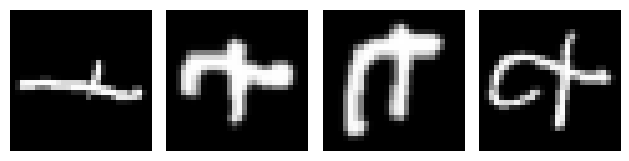

Label:  41


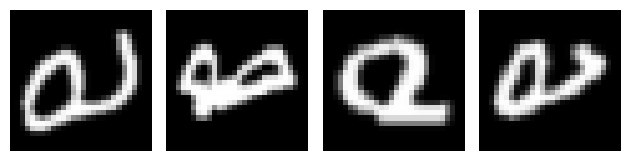

Label:  42


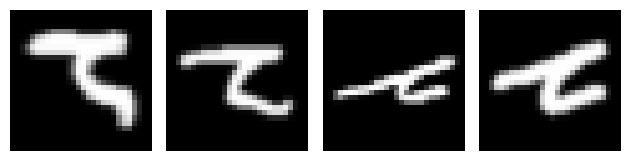

Label:  43


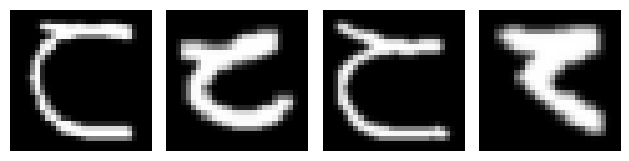

Label:  44


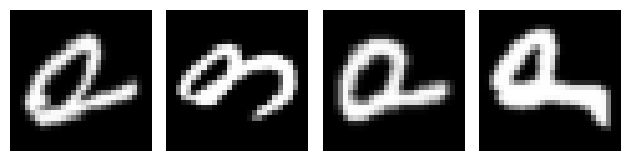

Label:  45


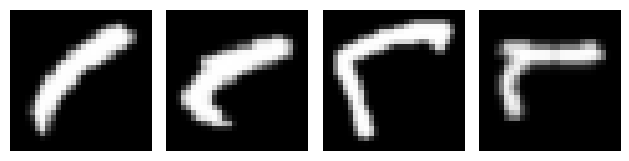

Label:  46


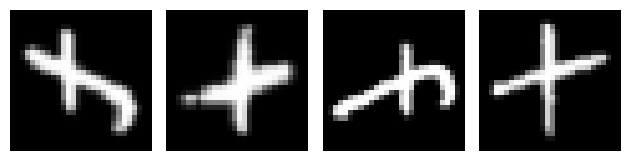

In [4]:
def plot_instances(data, label, n_instances=4):
    """
    Find and plot instances of the given class
    """
    fig, axes = plt.subplots(nrows=1, ncols=n_instances, tight_layout=True)
    # Find an image in the dataset with the right label
    print("Label: ", i)
    imgs = [img for (img, label) in data_train if label == i]
    for j, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(imgs[j].permute(1, 2, 0), cmap='gray')
        # Remove ticks
        ax.axis('off')
    plt.show()
    return fig, axes

n_classes = len(Counter([int(label) for _, label in data_train]))
for i in range(n_classes):
    plot_instances(data_train, label, n_instances=4)

#### Solutions

There are `47` classes (represented by an integer from `0` to `46`)
- digits from `0` to `9` 
- Upper case letters from `A` to `Z`
- **SOME (only `11/26`)** lower case letters, we note that `i`, `j`, `k` are missing for example.

All pictures consist of a single white character in a totally black background. We note also that images are also flipped. Each image is represented by a float tensor of dimension `1x28x28` with only one color channel (black and white image)

We can already notice that some classes are extremely similar and actually barely distinguishable for the human eye (`1` vs `l` vs `I` or `0` vs `o`). We will pay closer attention in the future about the confusion matrix concerning these classes. 

### 1.3 Analyse dataset

#### Tasks

Inspect the dataset. Do everything that seems relevant to you to have a better idea of the type of data you will play with. You can for example try to answer the following questions first:

- What is the range of values of the input? Its mean? And standard deviation? 
- How many instances are there in each class? 

See `02 - Machine learning pipeline and MNIST` for more information about counting instances of each class.


 ------- training dataset ------- 
Mean:  0.17360824346542358
Std:   0.331696480512619
Min:   0.0
Max:   1.0

Number of classes:               47
Biggest class:   1   occurrence:  5212
Smallest class:  26   occurrence:  330


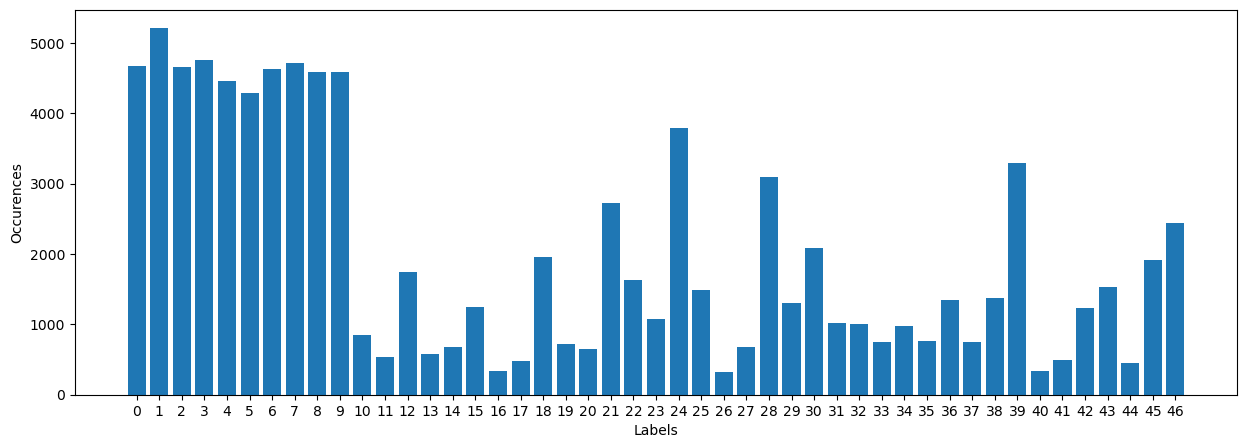


 ------- validation dataset ------- 
Mean:  0.17381443083286285
Std:   0.3317491114139557
Min:   0.0
Max:   1.0

Number of classes:               47
Biggest class:   1   occurrence:  571
Smallest class:  16   occurrence:  37


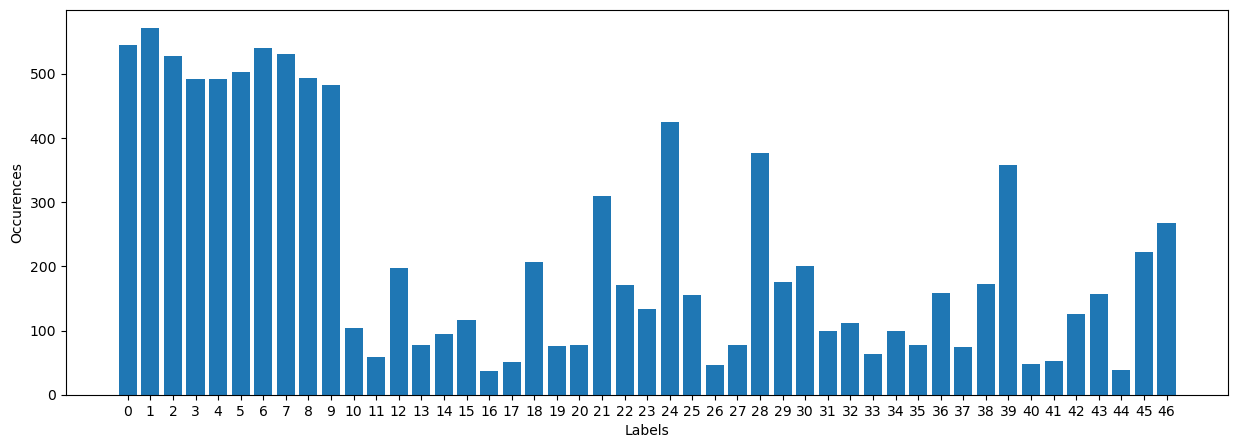


 ------- test dataset ------- 
Mean:  0.17321528494358063
Std:   0.33125999569892883
Min:   0.0
Max:   1.0

Number of classes:               47
Biggest class:   7   occurrence:  633
Smallest class:  40   occurrence:  34


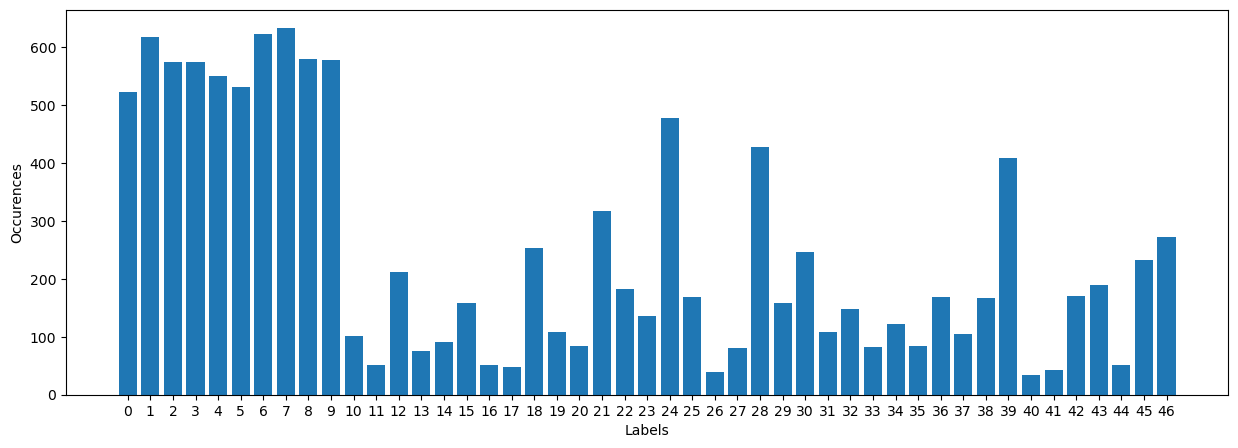

In [5]:
def compute_statistics(data):
    """
    Helper function to compute basic statistics in the 'analyse_dataset' 
    function
    """
    imgs = torch.cat([img for img, _ in data])
    mean = torch.mean(imgs).item()
    std = torch.std(imgs).item()
    amin = torch.min(imgs).item()
    amax = torch.max(imgs).item()
    print("Mean: ", mean)
    print("Std:  ", std)
    print("Min:  ", amin)
    print("Max:  ", amax)

def plot_histogram(counter):
    """
    Helper function to plot histogram of the number of instances in each 
    class in the 'analyse_dataset' function
    """
    # Convert to list of tuple (label, occurrences) sorted in decreasing order
    c = counter.most_common()
    n_classes = len(counter)
    
    labels = np.arange(n_classes)
    labels = [x[0] for x in c]
    occurrences = [counter[l] for l in labels]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.bar(labels, occurrences, tick_label=labels)
    ax.set_ylabel("Occurences")
    ax.set_xlabel("Labels")
    return fig, ax


def analyse_dataset(data):
    """
    Examples of basic analysis that one can perform on an unknown dataset.
    
    - Compute basic statistics
    - Find number of classes
    - Check occurences of each label in the dataset
    - Plot histogram
    """
    compute_statistics(data)
    
    # Count occurences
    counter = Counter([int(label) for _, label in data])
    
    # Total number of datapoints in the dataset
    n_tot = counter.total()
    
    # Total number of classes in the dataset
    n_classes = len(counter)
    
    # Convert to list of tuple (label, occurrences) sorted in decreasing order
    c = counter.most_common()
    
    print('\nNumber of classes:               %d' %len(c))
    print("Biggest class:   %d   occurrence:  %d" %(c[0][0], c[0][1]))
    print("Smallest class:  %d   occurrence:  %d" %(c[-1][0], c[-1][1]))
    
    
    fig, ax = plot_histogram(counter)
    plt.show()
    return counter

print("\n ------- training dataset ------- ")
counter_train = analyse_dataset(data_train)
print("\n ------- validation dataset ------- ")
counter_val = analyse_dataset(data_val)
print("\n ------- test dataset ------- ")
counter_test = analyse_dataset(data_test)

n_classes = len(counter_train)

#### Solutions

Some statistics on the pixel values:
- Range: `[0, 1]`
- Mean:  `0.1736`
- Std:   `0.3317` 

The distribution of the dataset is very imbalanced. We will have to pay closer attention in the future to the confusion matrix. Classes with many instances will probably be easier to learn than classes with few. As a consequences, the choice of performance measure should be chosen and / or interpreted wisely as well. There exist many options to tackle this unbalanced problem, such as the use of weighted loss functions, data augmentation, upsampling, downsampling, boosting, etc.

The training, validation and test dataset seem to have roughly the same distribution, which is reassuring.

**Note:** Analyzing the test dataset is "dangerous", if you are not sure whether what you are doing is "legal", don't do it. For example here, even if the test distribution was different, we wouldn't have been able to change it nor to adapt the other datasets to it. So whatever we find out about the test dataset, we shouldn't act on it and to be sure that we are not unconsciously acting on it, it is safer to actually avoid analyzing it.

### 1.4 Preprocess dataset

See `02 - Machine learning pipeline and MNIST` for more information about the preprocessing in general

#### Tasks

1. Instantiate a pytorch transforms to preprocess the dataset according to the analysis you just made.

In [6]:
weights = [counter_train[i]/counter_train.total() for i in range(n_classes)]
print("class weigths\n", weights)

imgs_train = torch.cat([img for img, _ in data_train])
mean = torch.mean(imgs_train).item()
std = torch.std(imgs_train).item()
print("Normalize with:\nMean    %.4f\nStd     %.4f" %(mean, std))
normalizer = transforms.Normalize(mean, std)

class weigths
 [0.049648702001655665, 0.0553161681985099, 0.04948950351297998, 0.05051898707308272, 0.047303177601833966, 0.04556260745897986, 0.04907558744242321, 0.04998832544416378, 0.048629831674131305, 0.048735963999915095, 0.00905308738935705, 0.0057523720574812675, 0.018530704081849248, 0.0061662881280380374, 0.007153318757827259, 0.013266540722973404, 0.003629725541805523, 0.005062511939886651, 0.020727643225573644, 0.00772643331705971, 0.006877374710789412, 0.02899535140413067, 0.017310182335335697, 0.0114729044172274, 0.0402029250068986, 0.01578187684404916, 0.0035023667508649785, 0.007185158455562396, 0.03285856806266053, 0.013765362654157204, 0.02208613699560612, 0.010772431067054403, 0.01063445904353548, 0.00797053766636242, 0.010326675298762498, 0.008108509689881345, 0.014242958120184246, 0.007991764131519178, 0.014529515399800472, 0.035013054276071404, 0.0036509520069622804, 0.005179257498248817, 0.013149795164611237, 0.01619579291460593, 0.0047122752648001524, 0.0202606

#### Example of solutions

We decided to have a very basic preprocessing pipeline. It is recommended to always start with a simple preprocessing and iteratively add steps if needed. We simply normalize the data based on the **training** mean and standard deviation of the pixel values (Note that we chose to compute the mean and standard deviation independently of the position of the pixel in the image here)

We don't flip the images, it wouldn't make it any easier for the machine learning methods, it is more for us humans, and for a simple exercise, we considered it not worth it. 

To tackle the imbalance issue, we compute the weights of each class to use it in some of our loss functions.


## 2. Machine learning pipeline

See practical exercise 2 `Machine learning pipeline and MNIST` for more information about the machine pipeline in general

### 2.1 Define different model architectures

#### Tasks

1. Define 3 different model architectures that are suitable to classify the images of the dataset.

In [7]:
H_in = 28
W_in= 28

class MyNet01(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(H_in*W_in, 256)
        self.fc2 = nn.Linear(256, n_classes)
    def forward(self, x):
        out = torch.flatten(x, 1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

class MyNet02(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(H_in//2 * W_in//2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_classes)
        
    def forward(self, x):
        out = torch.flatten(F.max_pool2d(x, 2), 1)
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

class MyNet03(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(H_in//2 * W_in//2, 512)
        self.fc2 = nn.Linear(512, n_classes)
        
    def forward(self, x):
        out = torch.flatten(F.max_pool2d(x, 2), 1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### 2.2 Utils: training loop and computing performance

See `02 - Machine learning pipeline and MNIST` for more information about the training loop in general

#### Tasks

1. Write a function ``train`` that 
   1. Trains the model for ``n`` epochs (complete passes through the training dataset)
   2. Computes and stores the training loss and the validation loss for each epoch
   3. Returns the list of training and validation losses

In [8]:
def set_device(device=None):
    """
    Helper function to set device
    """
    if device is None:
        device = (
            torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))
        print(f"On device {device}.")
    return device

def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device=None, preprocessor=normalizer):
    """
    Training loop that also computes the evolution of the validation loss
    See practical exercise 2 'Machine learning pipeline and MNIST'
    """

    device = set_device(device)
    
    optimizer.zero_grad()
    
    n_batch_train = len(train_loader)
    n_batch_val = len(val_loader)
    
    losses_train = []
    losses_val = []
    
    for epoch in range(1, n_epochs + 1):
        
        # Train model and compute training loss
        model.train()
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = preprocessor(imgs.to(device=device))
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch_train)
            
        # Compute validation loss
        model.eval()

        with torch.no_grad():
            loss_val = 0.0
            for imgs, labels in val_loader:
                
                imgs = preprocessor(imgs.to(device=device))
                labels = labels.to(device=device)

                outputs = model(imgs)
                loss_val += loss_fn(outputs, labels).item()
                
        losses_val.append(loss_val / n_batch_val)

        if epoch == 1 or epoch % 1 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.5f}  |  Validation loss {:.5f}'.format(
                datetime.now().time(), epoch,
                loss_train / n_batch_train, loss_val / n_batch_val))
            
    return (losses_train, losses_val)

def accuracy(expected, predicted):
    """
    Helper function to compute the accuracy in the 'compute_performance'
    function
    """
    return accuracy_score(expected, predicted, normalize=False)

def compute_confusion_matrix(expected, predicted):
    """
    Helper function to compute the confusion matrix in the 'compute_performance'
    function
    """
    return confusion_matrix(expected, predicted, labels=np.arange(n_classes))

def compute_performance(
    model, loader, performance = accuracy, normalize=True, device=None,
    preprocessor = normalizer,
):
    """
    Compute the performance of the model on the given dataset
    
    By default we compute the accuracy.
    Normalize determine whether we should divide by the number of inputs.
    This is helpful for the confusion matrix method or f1 score, etc.
    """
    device = set_device(device)
    
    model.eval()
    perf = 0.
    n_tot = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = preprocessor(imgs.to(device=device))
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            
            n_tot += len(imgs)
            perf += performance(labels.cpu(), predicted.cpu())

    if normalize:
        perf /= n_tot
    return perf

### 2.3 Define different model instances and train them all

#### Tasks

1. For each model architecture that you defined:
   1. create multiple instances and train them with different hyperparameters.
   2. store the training and validation loss for each model trained

In [9]:
def train_all(
    models, optimizers, loss_functions, data_train, data_val,
    n_epochs, batch_size, device=None, SEED=265,
):
    """
    Train a list of models and return the train and validation losses
    for each model
    """
    
    device = set_device()
    losses_train = []
    losses_val = []
    
    for i, (model, optimizer, loss_fn) in enumerate(zip(models, optimizers, loss_functions)):
        
        model.to(device=device)
        
        # All models with share *exactly* the same dataloaders (same shuffle)
        torch.manual_seed(SEED)
        train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

        # Regular training loop for one model
        loss_train, loss_val = train(
            n_epochs = n_epochs,
            optimizer = optimizer,
            model = model,
            loss_fn = loss_fn,
            train_loader = train_loader,
            val_loader = val_loader,
            device = device,
        )

        losses_train.append(loss_train)
        losses_val.append(loss_val)
    return losses_train, losses_val

In [10]:
device = set_device()
n_epochs = 30
batch_size = 512
class_weights = torch.tensor([1/w for w in weights]).to(device=device)

models = []
optimizers = []
loss_functions = []

# ----------  MyNet01() with diffenrent optimizers ----------

model = MyNet01()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-1))
loss_functions.append(nn.CrossEntropyLoss())

model = MyNet01()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-1, momentum=0.9))
loss_functions.append(nn.CrossEntropyLoss())

model = MyNet01()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-1, momentum=0.9))
loss_functions.append(nn.CrossEntropyLoss(weight=class_weights))

model = MyNet01()
models.append(model)
optimizers.append(optim.Adam(model.parameters(), lr=1e-2))
loss_functions.append(nn.CrossEntropyLoss())



# ---------- MyNet02() with diffenrent optimizers ----------

model = MyNet02()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-1))
loss_functions.append(nn.CrossEntropyLoss())

model = MyNet02()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-1, momentum=0.9))
loss_functions.append(nn.CrossEntropyLoss())

model = MyNet02()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-1, momentum=0.9))
loss_functions.append(nn.CrossEntropyLoss(weight=class_weights))

model = MyNet02()
models.append(model)
optimizers.append(optim.Adam(model.parameters(), lr=1e-2))
loss_functions.append(nn.CrossEntropyLoss())

# ---------- MyNet03() with diffenrent optimizers ----------

model = MyNet03()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-1))
loss_functions.append(nn.CrossEntropyLoss())

model = MyNet03()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-1, momentum=0.9))
loss_functions.append(nn.CrossEntropyLoss())

model = MyNet03()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-1, momentum=0.9))
loss_functions.append(nn.CrossEntropyLoss(weight=class_weights))

model = MyNet03()
models.append(model)
optimizers.append(optim.Adam(model.parameters(), lr=1e-2))
loss_functions.append(nn.CrossEntropyLoss())


On device cpu.


In [11]:
losses_train, losses_val = train_all(
    models, optimizers, loss_functions, data_train, data_val,
    n_epochs, batch_size,
)

On device cpu.
10:54:19.639611  |  Epoch 1  |  Training loss 1.51291  |  Validation loss 1.74411
10:54:21.346933  |  Epoch 2  |  Training loss 0.95913  |  Validation loss 1.31023
10:54:22.972229  |  Epoch 3  |  Training loss 0.82266  |  Validation loss 0.94785
10:54:25.134417  |  Epoch 4  |  Training loss 0.73447  |  Validation loss 1.13294
10:54:26.761084  |  Epoch 5  |  Training loss 0.67804  |  Validation loss 1.55622
10:54:28.325897  |  Epoch 6  |  Training loss 0.63442  |  Validation loss 0.96497
10:54:29.840382  |  Epoch 7  |  Training loss 0.59292  |  Validation loss 0.91245
10:54:31.423762  |  Epoch 8  |  Training loss 0.56246  |  Validation loss 0.76364
10:54:32.873797  |  Epoch 9  |  Training loss 0.53664  |  Validation loss 0.72852
10:54:34.541906  |  Epoch 10  |  Training loss 0.51380  |  Validation loss 0.63451
10:54:36.930839  |  Epoch 11  |  Training loss 0.49823  |  Validation loss 0.96233
10:54:38.415613  |  Epoch 12  |  Training loss 0.48827  |  Validation loss 0.7459

### 2.4 Analysis of the evolution of the training and validation losses for each model

#### Tasks

1. For each of your trained models, plot the training loss and the validation loss. See `02 - Machine learning pipeline and MNIST` for more information about how to plot the training loss and the validation loss. 
2. Analyse your plots. For example, you can try to answer the following questions:
   1. Are you results so unexpected that you think you should look for a bug in your code? For example, if the validation loss is much better that the training loss, or the losses are constants or if the training loss is increasing, etc. 
   2. Are results so disappointing that you think you should go back to `1. Analyse data` because of a misunderstanding concerning the content of the dataset or an inappropriate preprocessing?
   3. Are some models overfitting/underfitting? 
   4. Do some architectures perform systematically better than others? Do you think you should go back to `2.1. Define different model architectures` and define new models?
   5. Do some sets of hyperparameters systematically yield a better/worse performance than other? Do you think you should go back to `3. Define different model instances and train them all`?
   

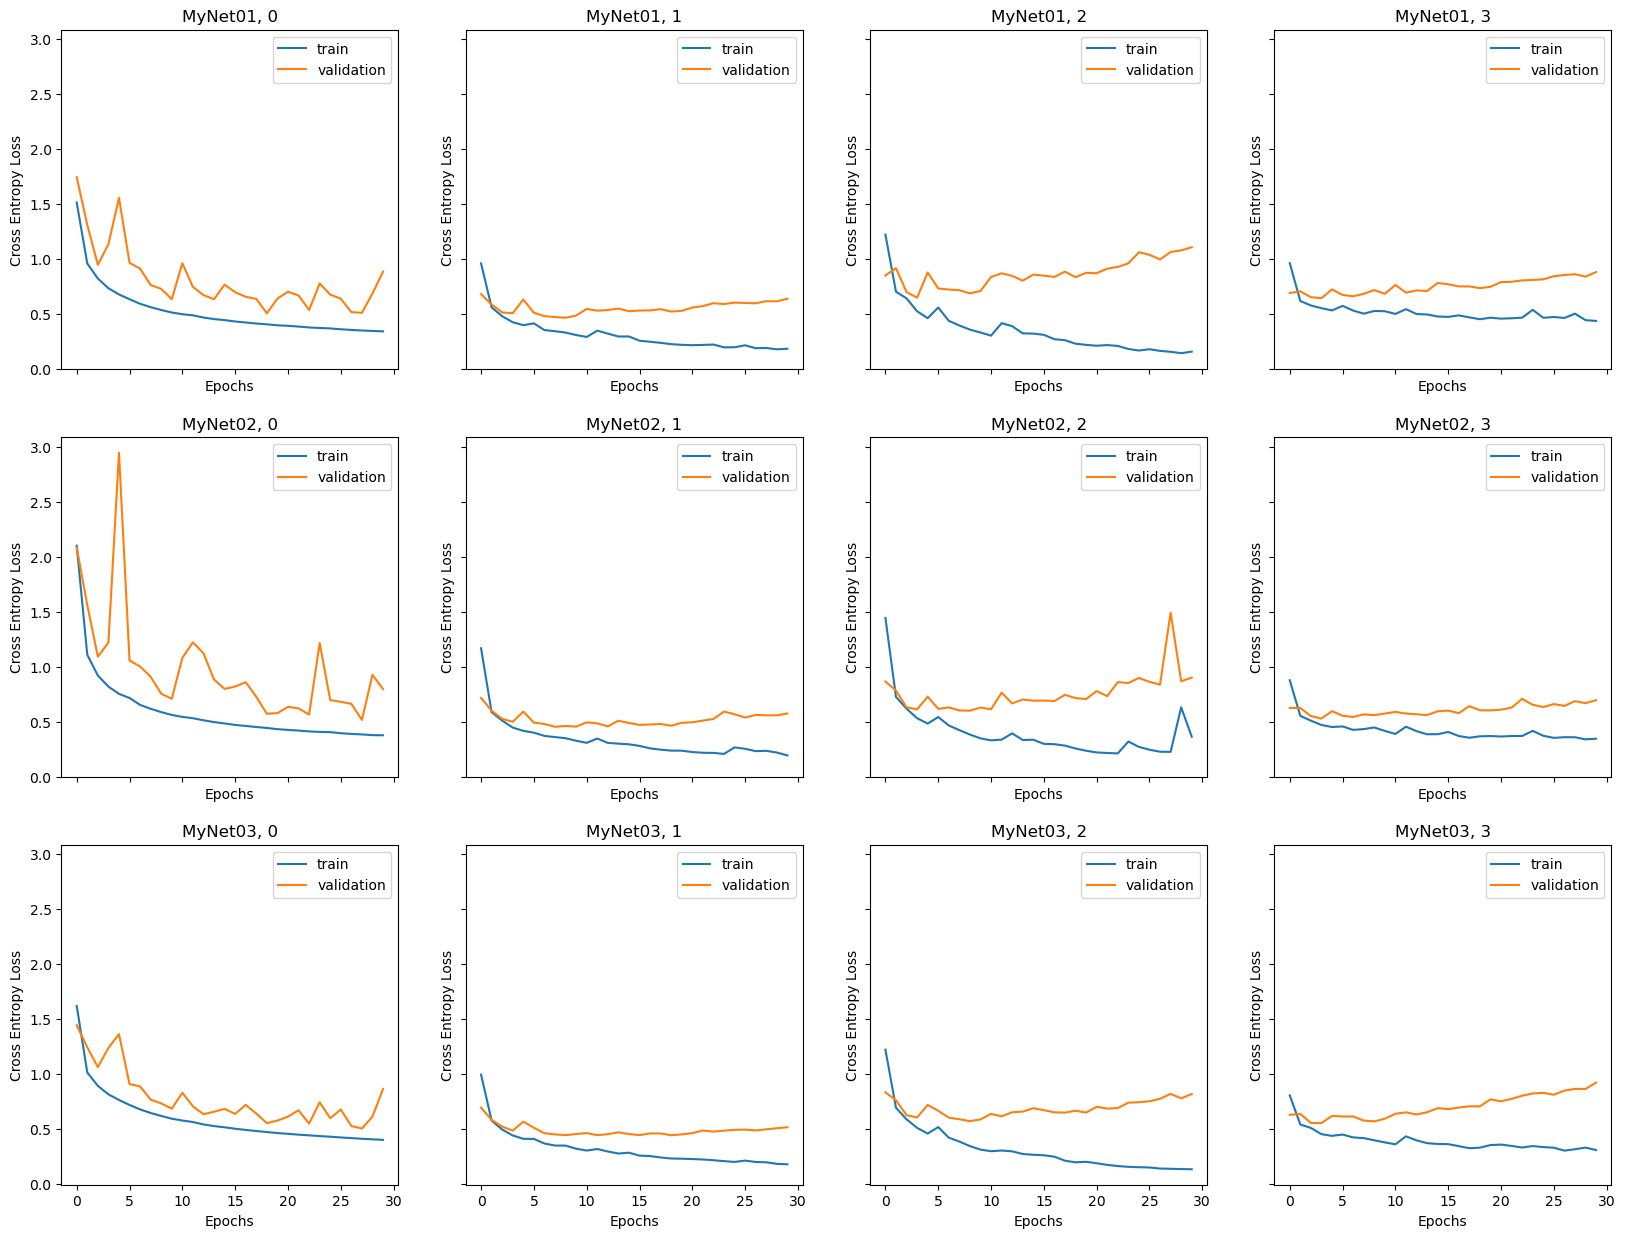

In [12]:
n_model = len(models)
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True, sharex=True)

# Plot the evolution of the training and validation losses for each model
for i, ax in enumerate(axes.flat):

    name = models[i].__class__.__name__ + ", " + str(i % 4)
    ax.plot(losses_train[i], label='train')
    ax.plot(losses_val[i], label='validation')
    ax.set_title(name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cross Entropy Loss')
    ax.legend()

plt.show()

#### Example of solutions

In the plots above, each row uses a different model architecture and each column uses a different set of hyperparameters. We can see the evolution of the training and validation losses with respect to the number of training epochs.

All models seem to be learning to some degree, there is no apparent sign of problem in the pipeline.

Some models are clearly overfitting (in particular column 3). Some models are unstable (column 1). And overall, we can see that for models in columns 2, 3 and 4, the validation loss starts increasing after a few epochs. This is not a good sign, we should probably go back to `3. Define different model instances and train them all` and try other sets of hyperparameters. One direction we could take is to find inspiration in the set of hyperparameters used in the column 2 and try out different measures to prevent overfitting, so that the overfitting does not worsen with increasing number of epochs.

For the sake of the exercise though, we keep these models and don't go back to `3. Define different model instances and train them all`.

### 2.5 Analysis of the confusion matrix of each model on the validation dataset

#### Tasks

1. For each trained model, plot the confusion matrix of the validation dataset. To do so:
   1. Compute the confusion matrix. You can use `sklearn.metrics.confusion_matrix` (remember to use `.cpu()` on Pytorch tensors right before using a library outside Pytorch)
   2. Plot the obtained confusion matrix. You can use the `plot_confusion_matrix` function.
2. Analyse the confusion matrix. For example, you can try to answer the following questions
   1. Are the different classes equally well (mis-)classified? 
   2. For each class, does the model tend to misclassify the input with some other specific classes? Do you know why?

In [13]:
def plot_confusion_matrix(matrix, ax=None):
    """
    Plot the given confusion matrix
    """
    ax = sns.heatmap(
        data=matrix.round(2),
        cmap=sns.color_palette("dark:salmon", 1000), ax=ax
    )
    return ax

On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.
On device cpu.


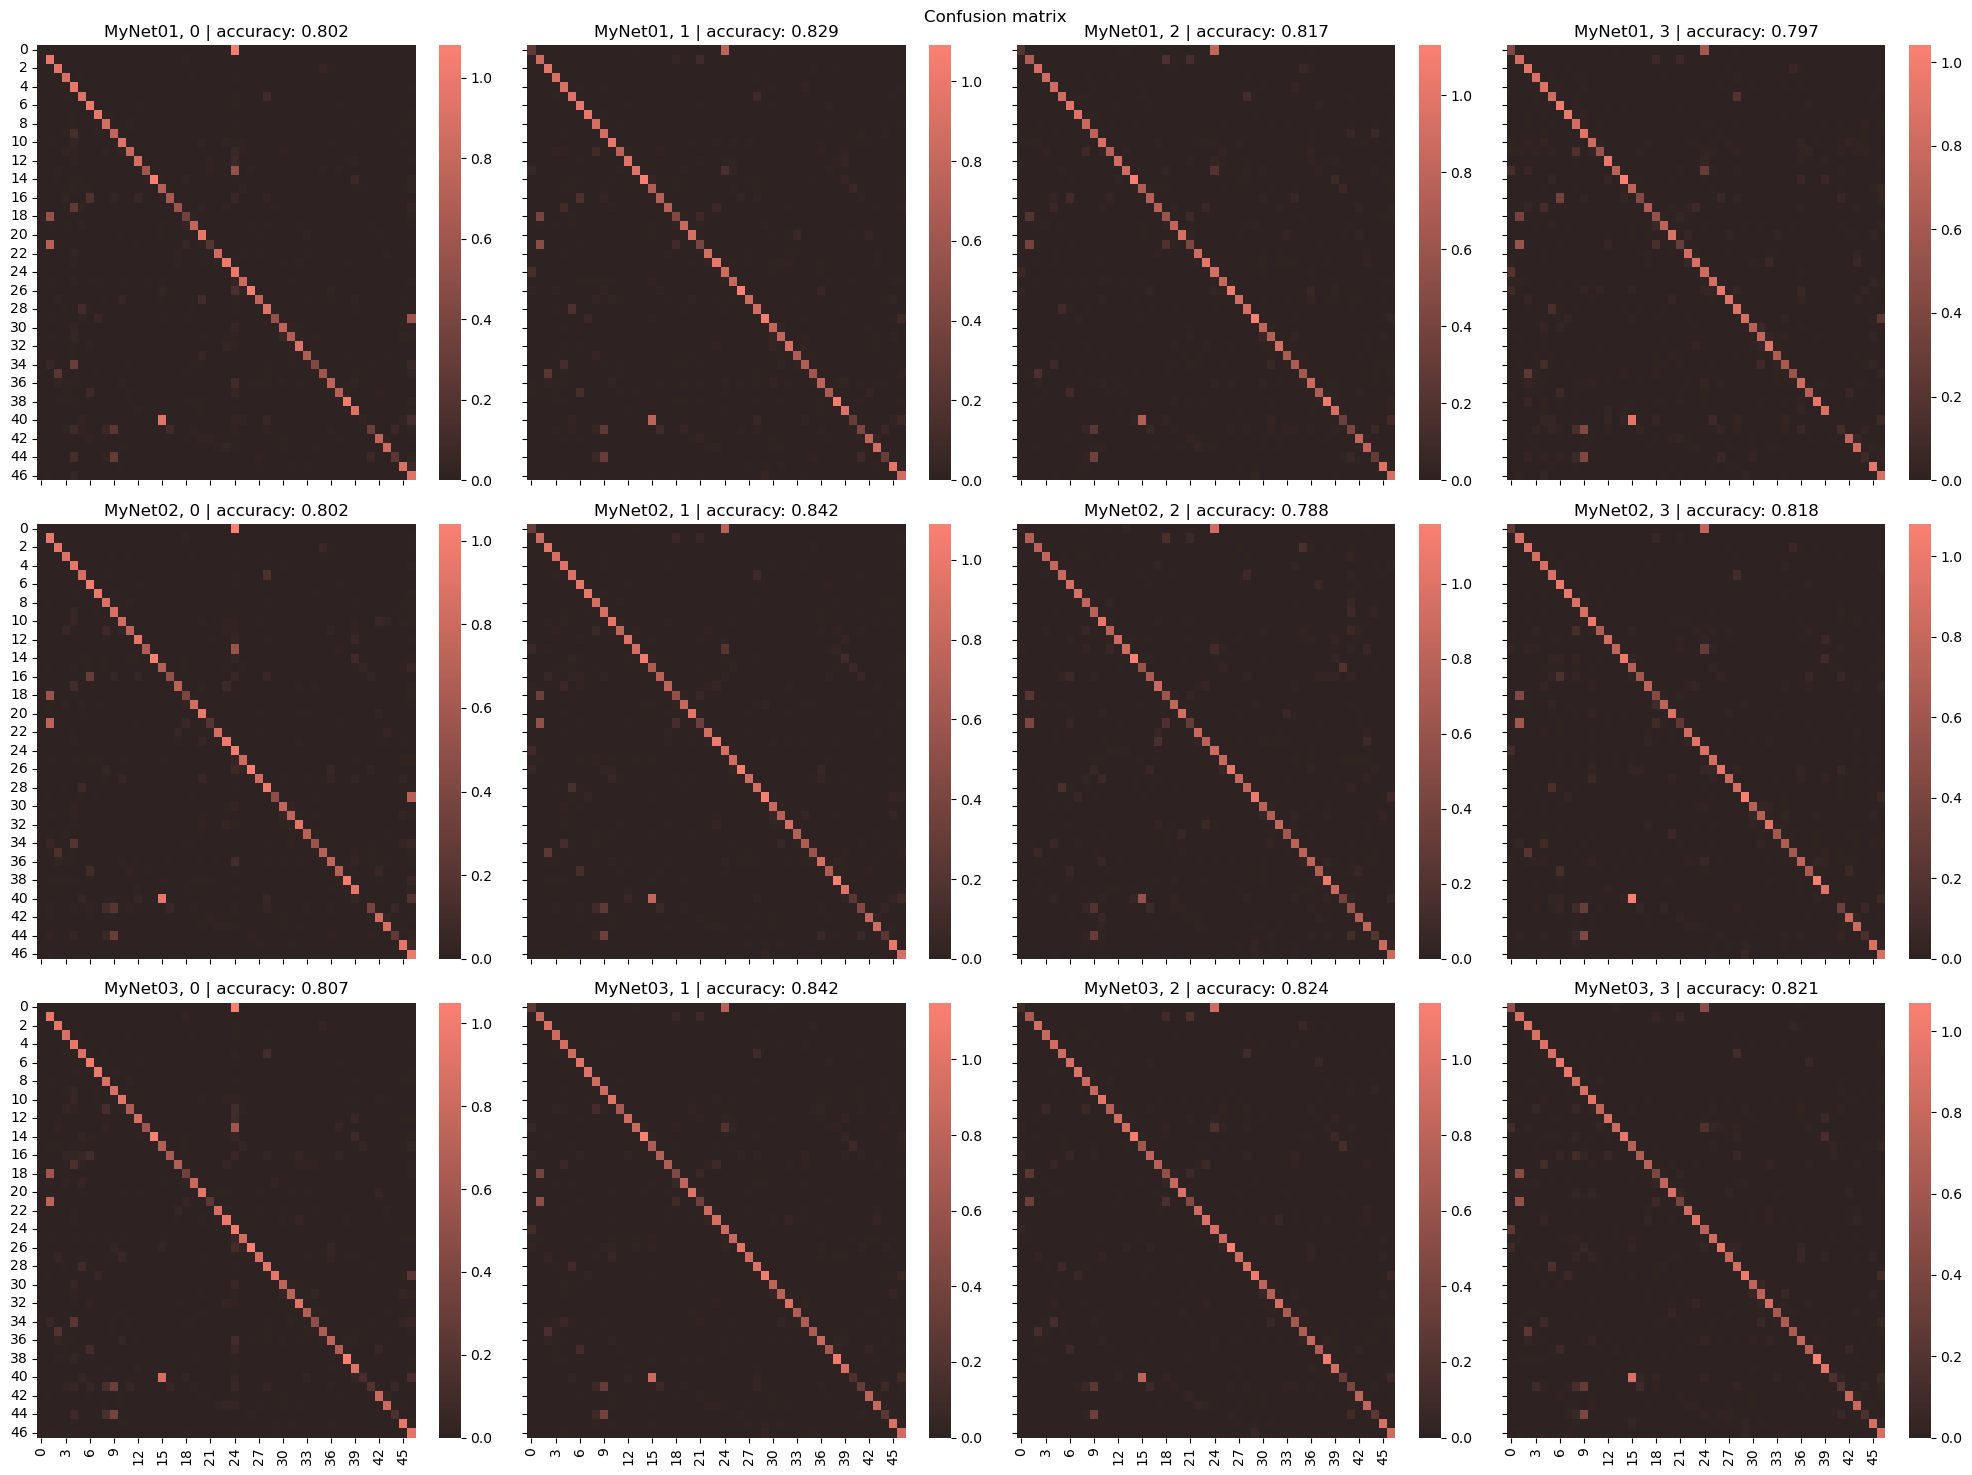

In [14]:
val_loader = torch.utils.data.DataLoader(data_val, batch_size=512, shuffle=False)
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True, sharex=True)

# Plot the confusion matrix of each model on the validation dataset
for i, ax in enumerate(axes.flat):

    acc = compute_performance(
        models[i], val_loader, 
        performance=accuracy, normalize=True
    )

    # Compute (non-normalized) confusion matrix
    matrix = compute_performance(
        models[i], val_loader, 
        performance=compute_confusion_matrix, normalize=False
    )
    
    # Normalize matrix
    for j in range(len(matrix)):
        matrix[j] = matrix[j] / (weights[j]*len(data_val))
    
    # Plot matrix
    ax = plot_confusion_matrix(matrix, ax)
    name = models[i].__class__.__name__ + ", " + str(i % 4) + " | accuracy: " + str(round(acc, 3))
    ax.set_title(name)

fig.suptitle("Confusion matrix")
plt.tight_layout()
plt.show()

#### Example of solutions

In the plots above, each row uses a different model architecture and each column uses a different set of hyperparameters. The confusion matrix for validation dataset.

All models look to perform "decently" overall, given how hard the task is initially (imbalanced dataset, some classes are very similar and the size of the dataset isn't that big after all). Nevertheless, we can see that some classes are systematically misclassified in all cases:

- classes `0` and `24` so `0` and `o` (although we have a large amount of instances for both cases, according to our plots in section 1.)
- classes `1`, `18` and `21`, so `1`, `I` and `l`
- classes `15` and `40`, so `f` and `F`

Which are all classes that also look very similar to the human eye (not to say indistinguishable), according to our plots in section 1.


Some classes are never being predicted (or rarely predicted, we can see that models 2 and 3 are performing better for this problem, especially when using weighted loss and/or momentum) by the models:

- `40`, `41`, `44`, so `f`, `g` and `q`, which also corresponds to classes that have very few instances.
- `0`, so `0`.

When seeing such bad performance for some classes, it would be expected to go back to `3. Define different model instances and train them all` or even back to data preprocessing, given the fact that we saw in section 1. that for instance classes `40`, `41` `44` have very few classes. But here again, we continue for the sake of the exercise.

### 2.6 Model Selection

See `02 - Machine learning pipeline and MNIST` for more information about model selection.

#### Tasks

1. Choose a performance measure. Justify your choice.
2. Select the best model based on the validation performance

In [15]:
def model_selection(models, data_train, data_val, device=None):
    """
    Select the best model based on the validation performance
    """
    device = set_device()
    batch_size = 512

    perf_train = []
    perf_val = []
    
    # Compute all training and validation performance
    for i, model in enumerate(models):
        print(" ============= model %d ============= " %i)
        
        model.to(device=device)
        train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=False)
        val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=False)
        
        acc = compute_performance(model, train_loader, accuracy, device=device)
        perf_train.append(acc)
        print("Training Accuracy:     %.4f" %acc)
        acc = compute_performance(model, val_loader, accuracy, device=device)
        perf_val.append(acc)
        print("Validation Accuracy:   %.4f" %acc)
        
    # Select the best model based on the validation performance
    i_best_model = np.argmax(perf_val)
    return perf_train, perf_val, i_best_model

In [16]:
perf_train, perf_val, i_best_model = model_selection(models, data_train, data_val)

best_model = models[i_best_model]
print("\nThe best model is: ")
print(" ----------------------------------------- ")
print(" Model:           ", models[i_best_model])
print(" Optimizer:       ", optimizers[i_best_model])
print(" Loss function:   ", loss_functions[i_best_model])
print(" ----------------------------------------- ")
print("\n Performance:   ")
print(" ----------------------------------------- ")
print(' Training:        %.4f' %perf_train[i_best_model])
print(' Validation:      %.4f' %perf_val[i_best_model])
print(" ----------------------------------------- ")

On device cpu.
 ============= model 0 ============= 
Training Accuracy:     0.8353
Validation Accuracy:   0.8020
 ============= model 1 ============= 
Training Accuracy:     0.9270
Validation Accuracy:   0.8292
 ============= model 2 ============= 
Training Accuracy:     0.9012
Validation Accuracy:   0.8167
 ============= model 3 ============= 
Training Accuracy:     0.8539
Validation Accuracy:   0.7966
 ============= model 4 ============= 
Training Accuracy:     0.8276
Validation Accuracy:   0.8021
 ============= model 5 ============= 
Training Accuracy:     0.9190
Validation Accuracy:   0.8415
 ============= model 6 ============= 
Training Accuracy:     0.8311
Validation Accuracy:   0.7878
 ============= model 7 ============= 
Training Accuracy:     0.8735
Validation Accuracy:   0.8181
 ============= model 8 ============= 
Training Accuracy:     0.8309
Validation Accuracy:   0.8074
 ============= model 9 ============= 
Training Accuracy:     0.9251
Validation Accuracy:   0.8420
 ====

### 2.7 Model evaluation

See `02 - Machine learning pipeline and MNIST` for more information about model evaluation.

#### Tasks

1. Evaluate the performance of the selected model on the test dataset.
2. Analyse your result. For example, you can try to answer the following questions :

   1. Are your results surprising? In other words, relative to your general knowledge in machine learning, your understanding of the data and the problem, and relative to the conﬁdence you put in your design choices and implementation, did you expect such performance?
   2. Are your results satisfying? In other words, is your model better than random outputs? Does your model outperform any baseline model? Do you think you could use your model in real life? 


In [17]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False)

test_acc = compute_performance(best_model, test_loader, accuracy)
print("Test performance of the best model:    %.4f" %test_acc)

On device cpu.
Test performance of the best model:    0.8481


## 3. Analyse Results

We would like to analyse the performance of our model a bit further, in order to be able to communicate on its qualities and limits.

### 3.1 Plot confusion matrix

#### Tasks

1. Plot the confusion matrix of the best model on the test dataset.
2. Analyse the confusion matrix. For example, you can try to answer the following questions
   1. Are the different classes equally well (mis-)classified? 
   2. For each class, does the model tend to misclassify the input with some other specific classes? Do you know why?

On device cpu.


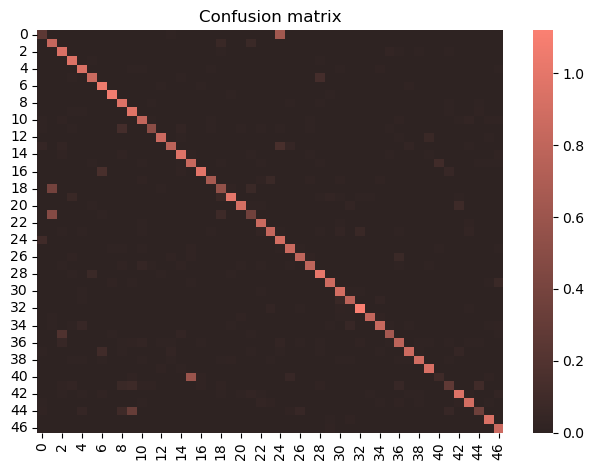

In [18]:
# Compute (non-normalized) confusion matrix
matrix = compute_performance(
    best_model, test_loader, 
    performance=compute_confusion_matrix, normalize=False
)

# Normalize matrix
for j in range(len(matrix)):
    matrix[j] = matrix[j] / (weights[j]*len(data_test))
ax = plot_confusion_matrix(matrix)

plt.title("Confusion matrix")
plt.tight_layout()
plt.show()

### 3.2 Plot examples of misclassified inputs

#### Tasks

1. For each class, plot examples of misclassified inputs together with their predicted class

In [19]:
def find_examples_inputs(
    model, loader, wrong=True, label=None, device=None, preprocessor=normalizer,
):
    """
    Find example of inputs (with their corresponding predictions) that 
    matches the given condition.
    
    If `wrong=True`, misclassified examples are kept.
    Otherwise, correctly classified examples are kept.
    
    If label is not None, keep only found examples that are of the given label
    Otherwise, keep all examples that were found.
    """
    device = set_device(device)
    
    model.eval()
    kept_imgs = []
    kept_labels = []
    kept_preds = []

    with torch.no_grad():
        for imgs_raw, labels in loader:
            imgs_raw = imgs_raw.to(device=device)
            imgs = preprocessor(imgs_raw)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            
            # Define the condition on the indices
            if wrong:
                indices = labels != predicted
            else: 
                indices = labels == predicted
            if label is not None:
                indices &= labels == label
                
            # Keep only inputs and predictions that match the conditions
            kept_imgs += (imgs_raw[indices])
            kept_labels += (labels[indices])
            kept_preds += (predicted[indices])
            
    return kept_imgs, kept_labels, kept_preds

 =========== Label 0 =========== 
On device cpu.


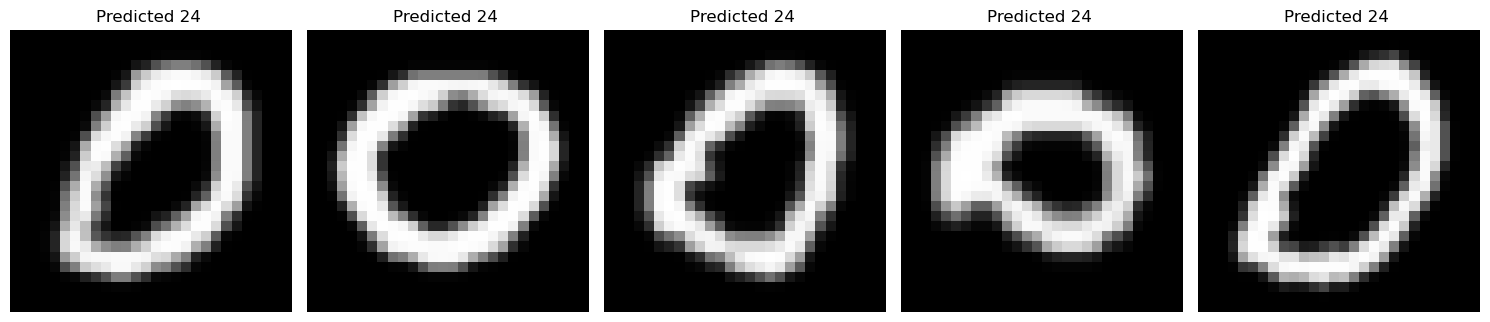

 =========== Label 1 =========== 
On device cpu.


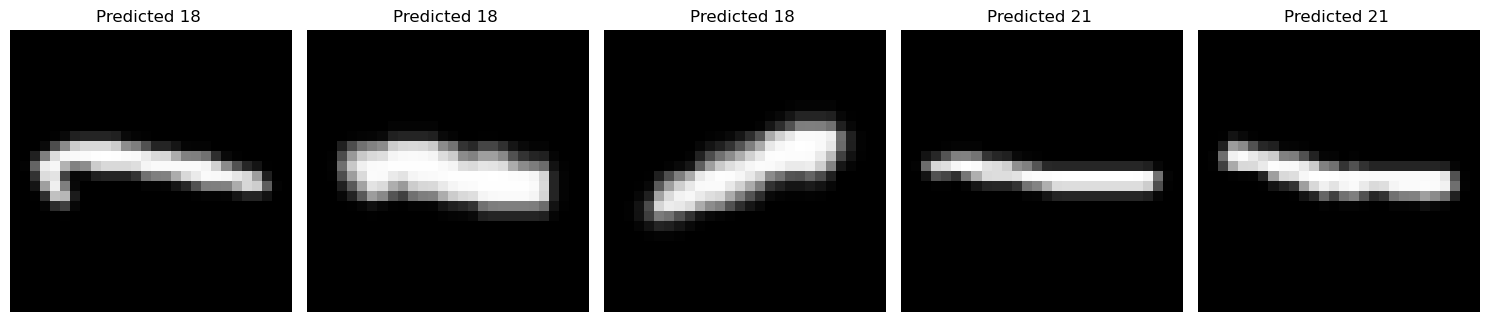

 =========== Label 2 =========== 
On device cpu.


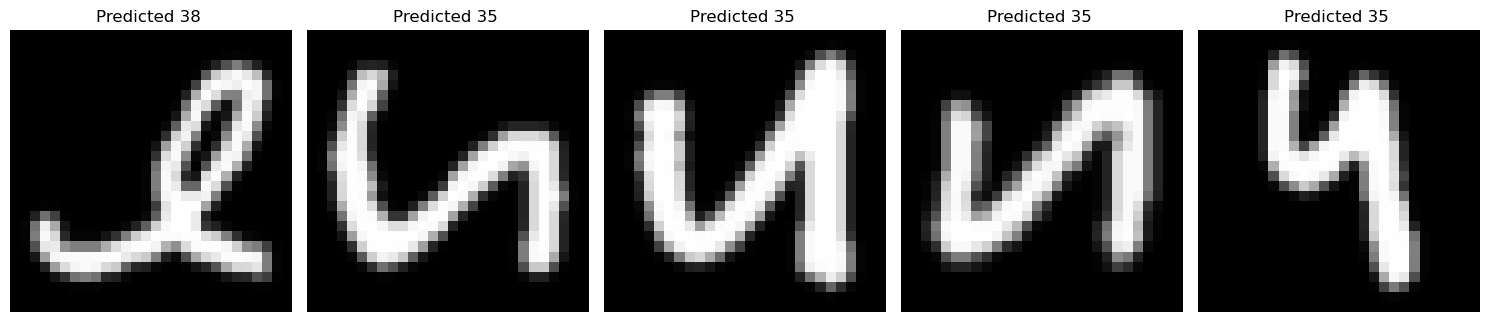

 =========== Label 3 =========== 
On device cpu.


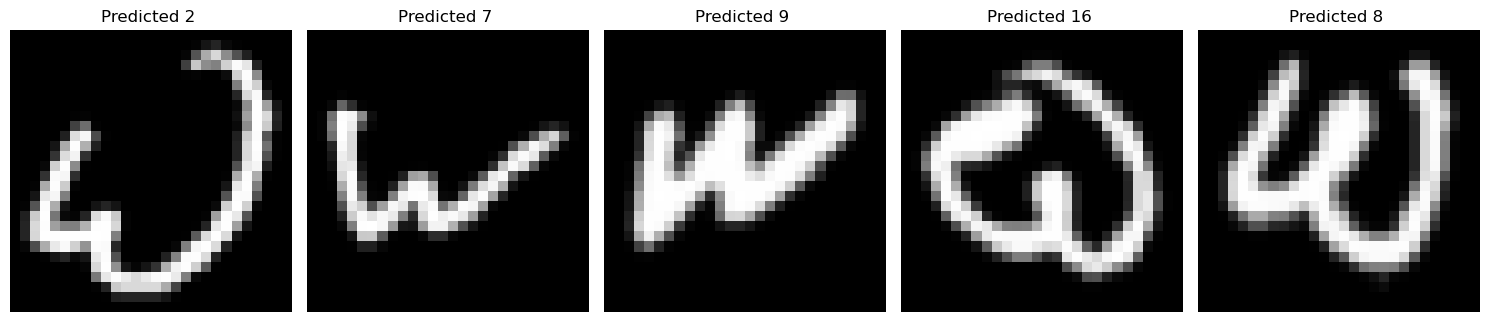

 =========== Label 4 =========== 
On device cpu.


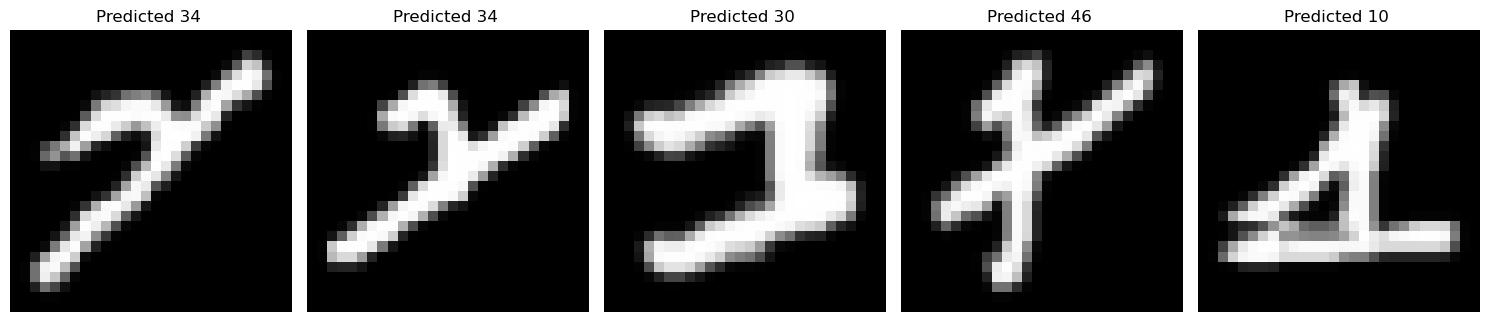

 =========== Label 5 =========== 
On device cpu.


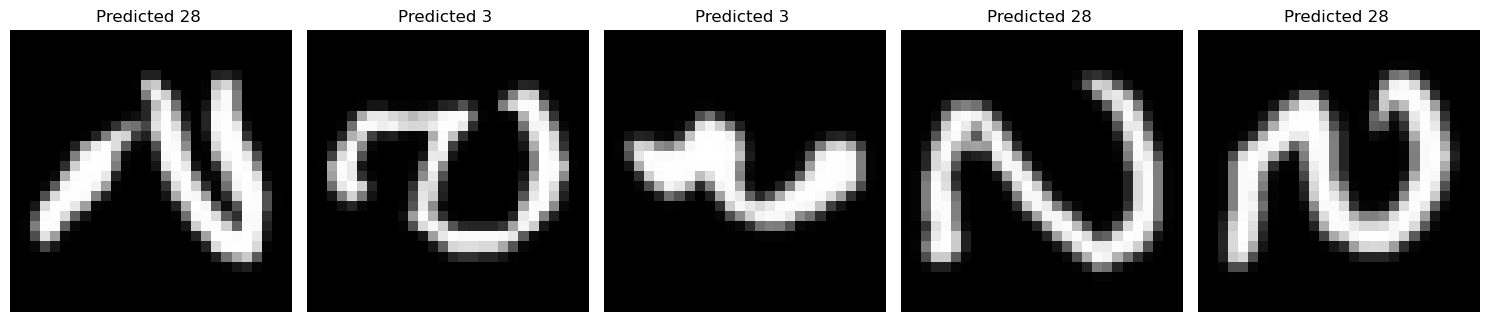

 =========== Label 6 =========== 
On device cpu.


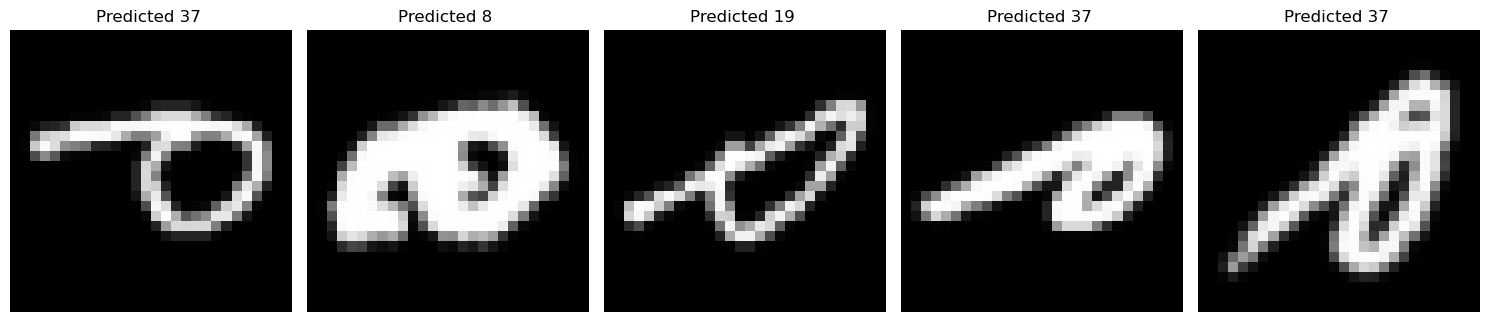

 =========== Label 7 =========== 
On device cpu.


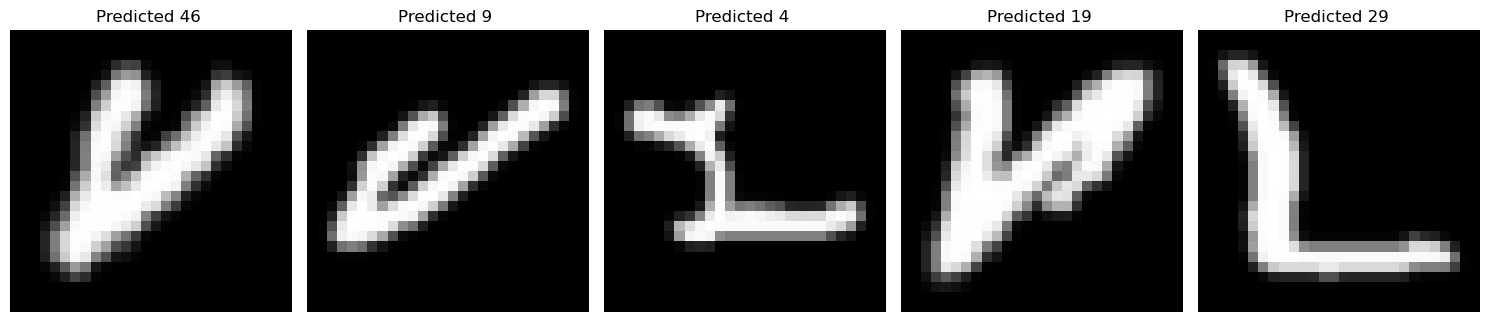

 =========== Label 8 =========== 
On device cpu.


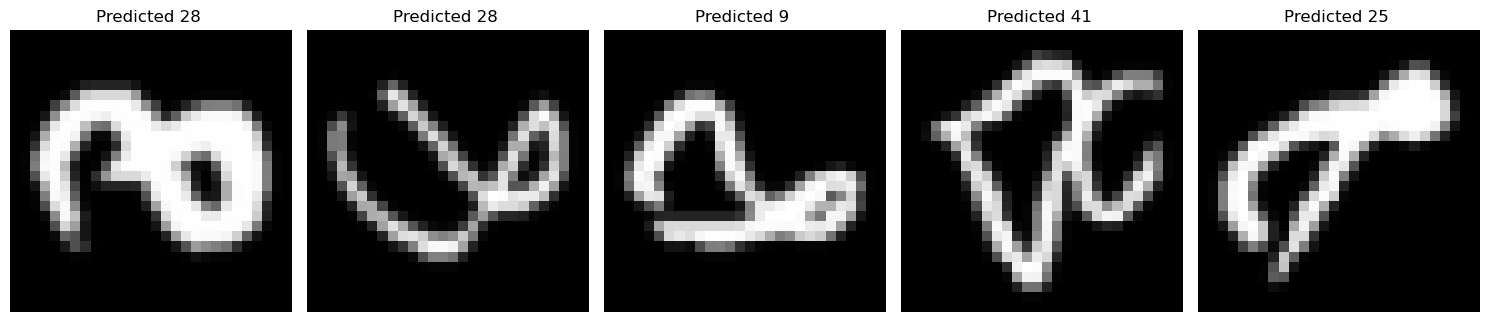

 =========== Label 9 =========== 
On device cpu.


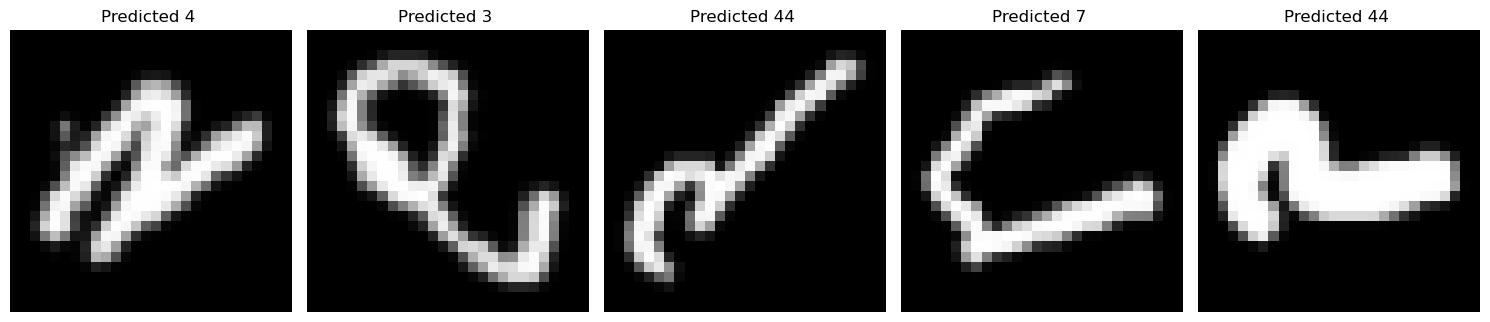

 =========== Label 10 =========== 
On device cpu.


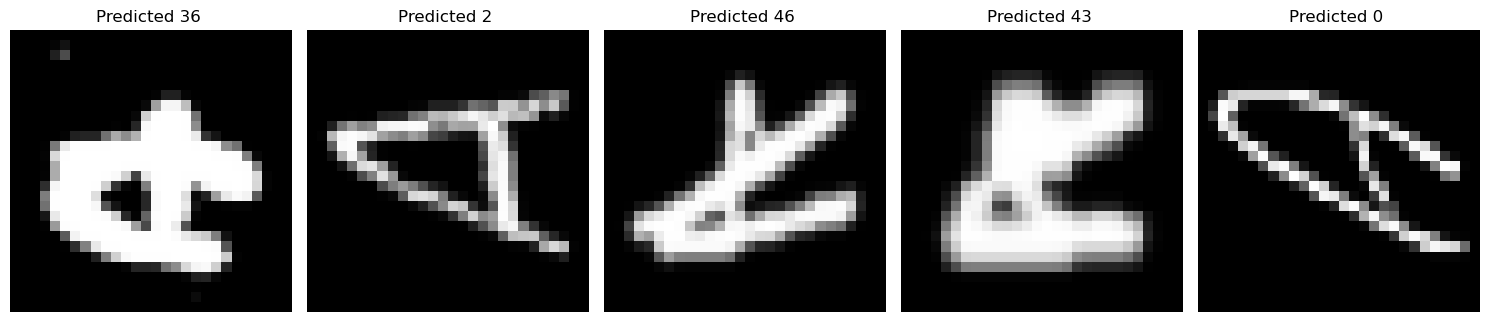

 =========== Label 11 =========== 
On device cpu.


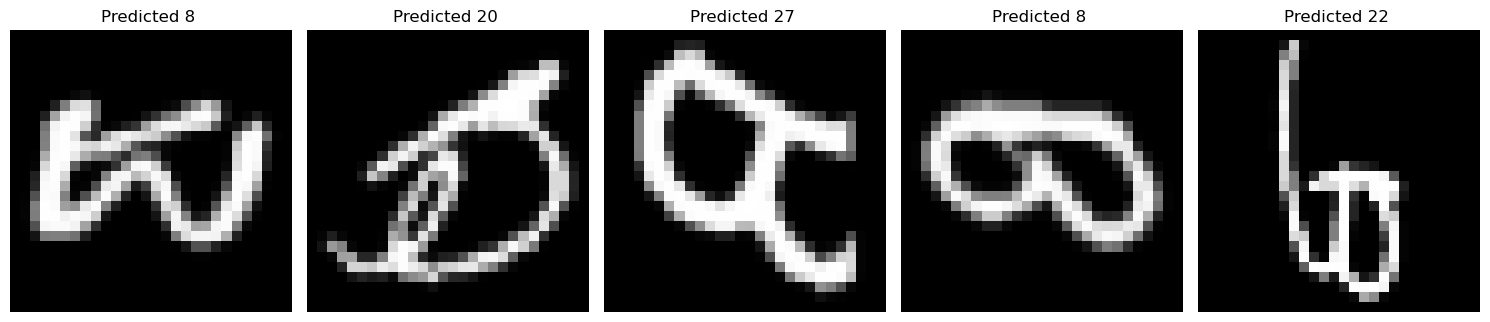

 =========== Label 12 =========== 
On device cpu.


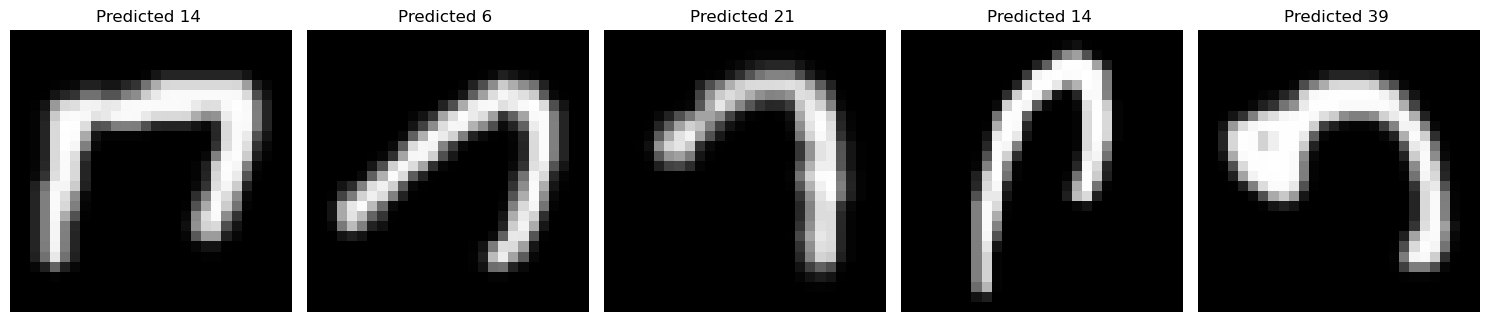

 =========== Label 13 =========== 
On device cpu.


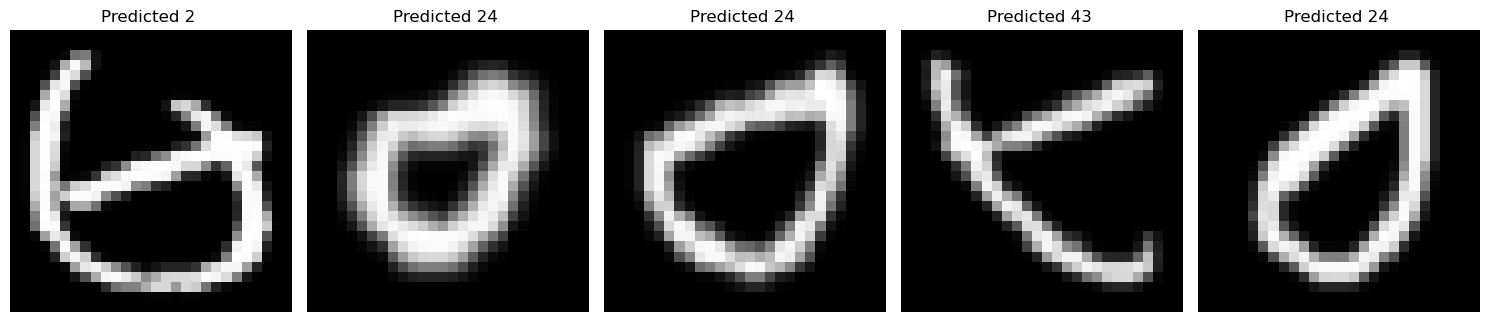

 =========== Label 14 =========== 
On device cpu.


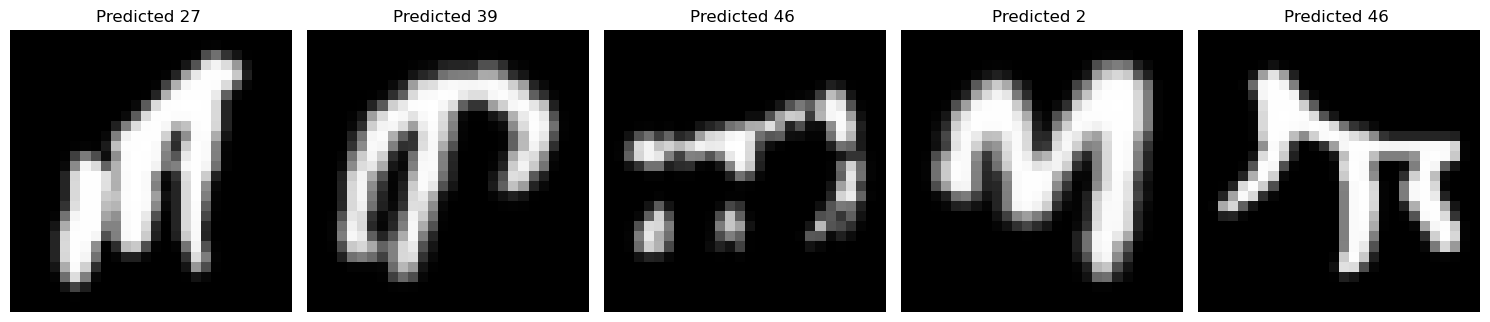

 =========== Label 15 =========== 
On device cpu.


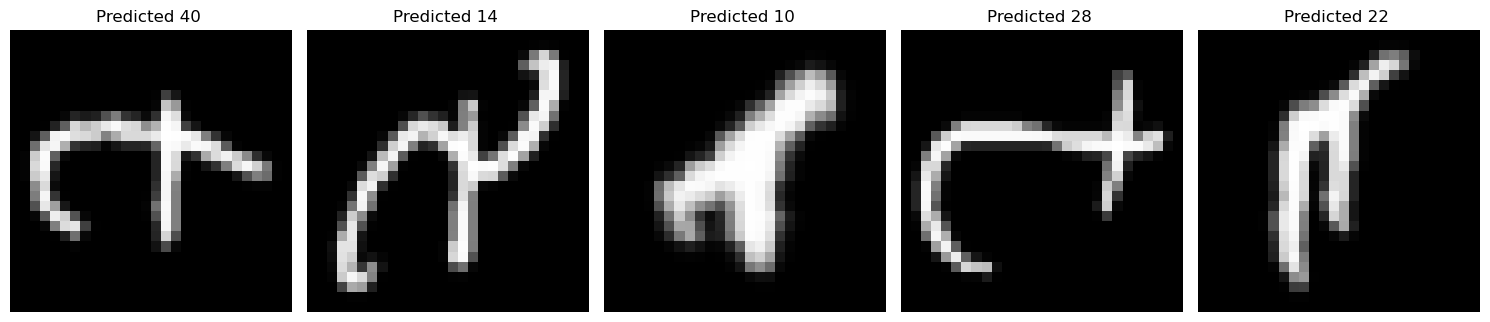

 =========== Label 16 =========== 
On device cpu.


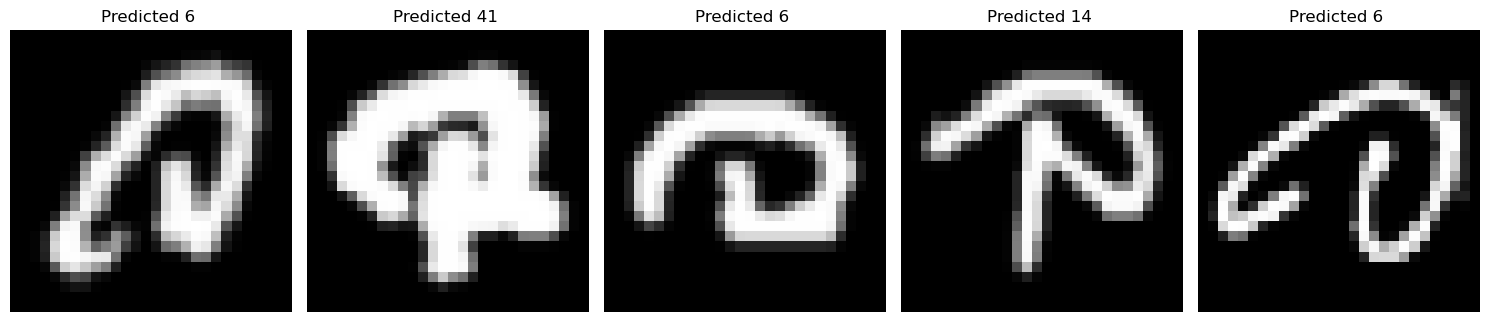

 =========== Label 17 =========== 
On device cpu.


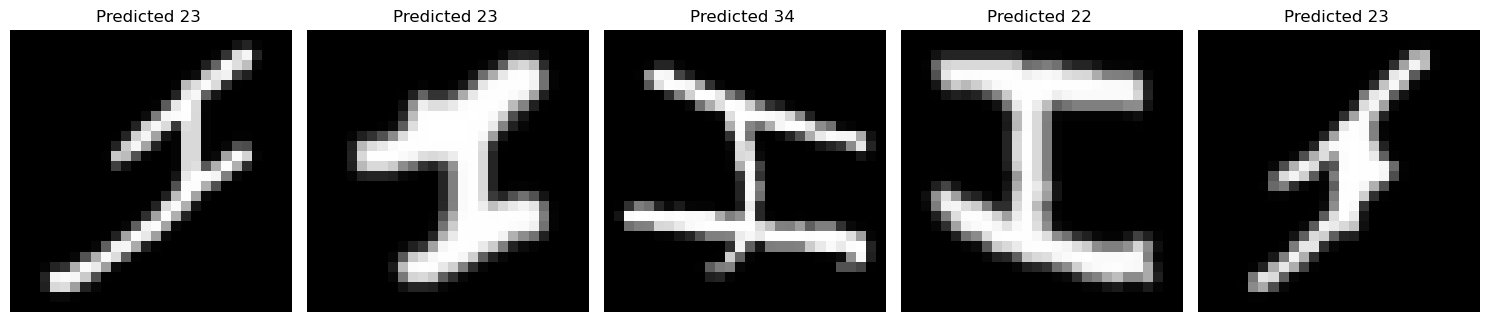

 =========== Label 18 =========== 
On device cpu.


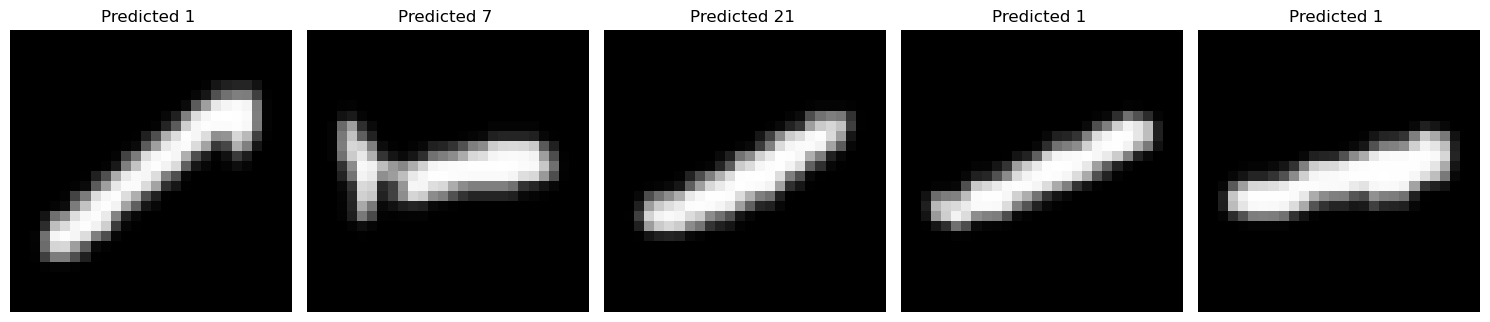

 =========== Label 19 =========== 
On device cpu.


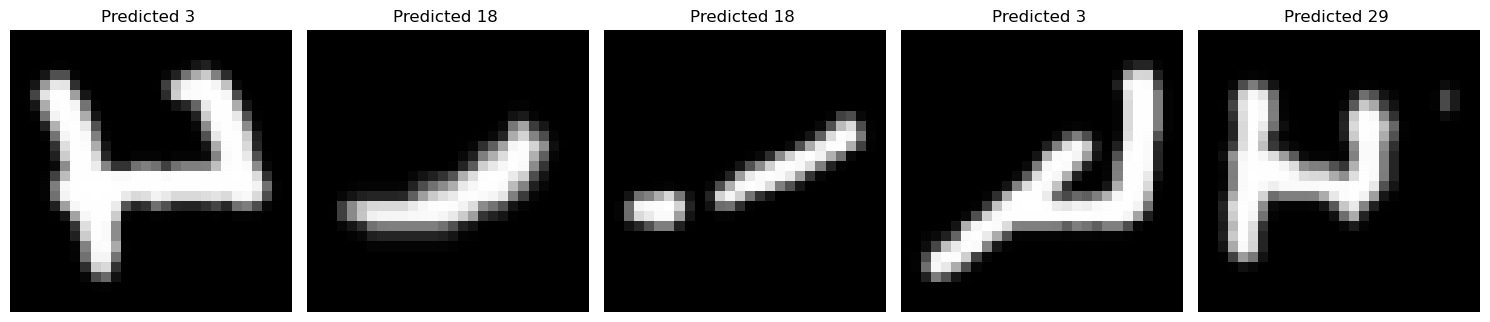

 =========== Label 20 =========== 
On device cpu.


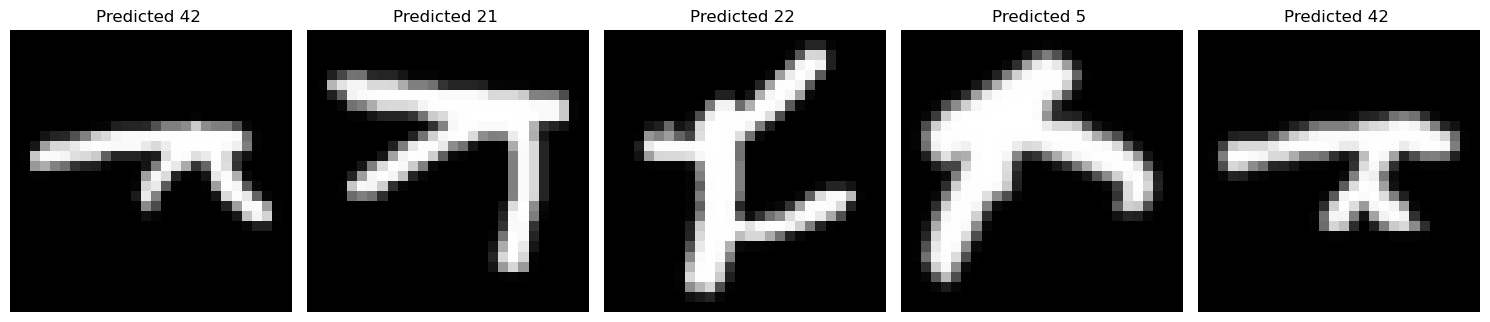

 =========== Label 21 =========== 
On device cpu.


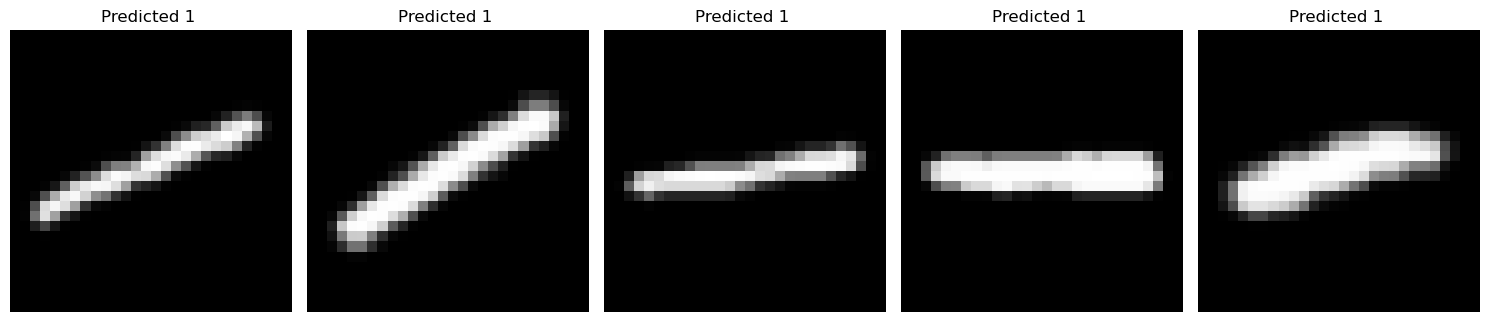

 =========== Label 22 =========== 
On device cpu.


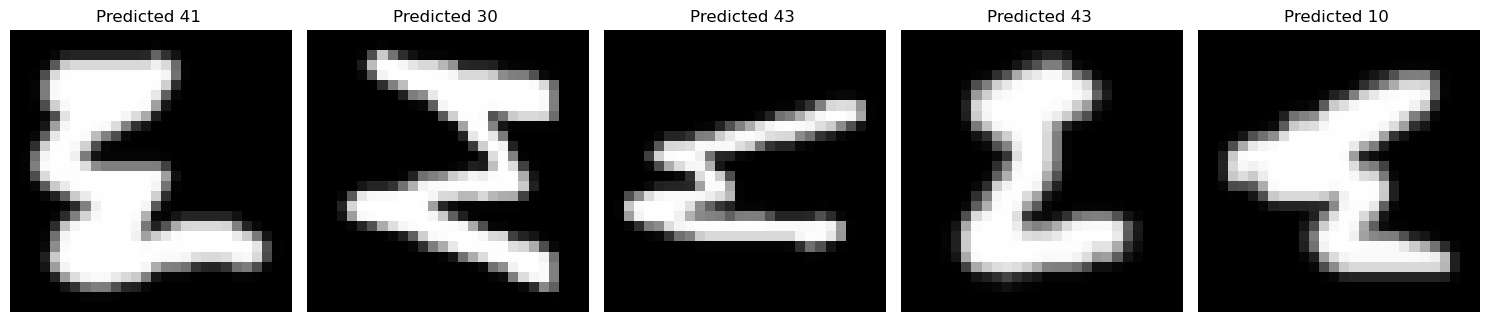

 =========== Label 23 =========== 
On device cpu.


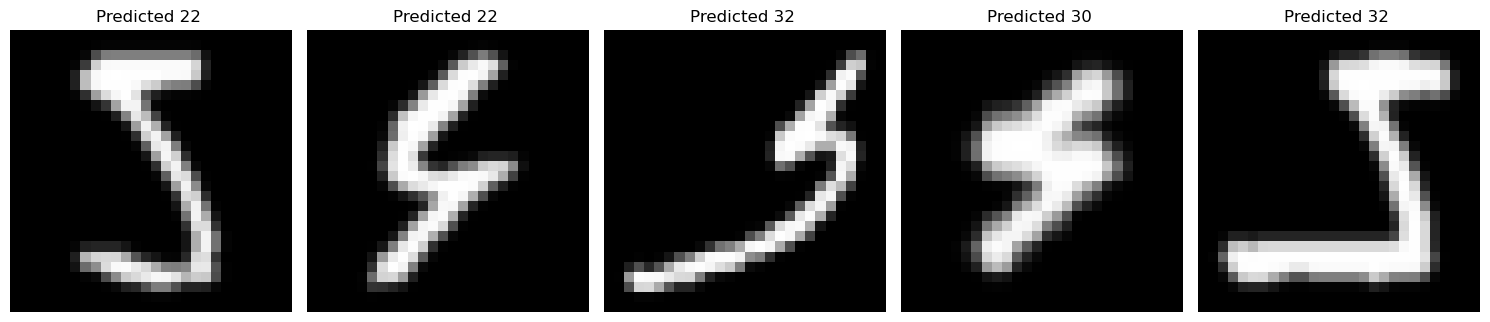

 =========== Label 24 =========== 
On device cpu.


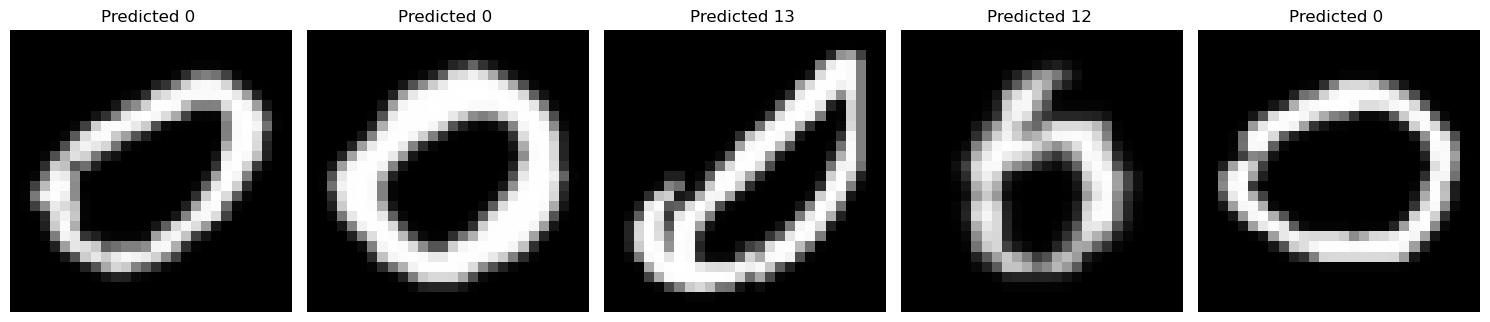

 =========== Label 25 =========== 
On device cpu.


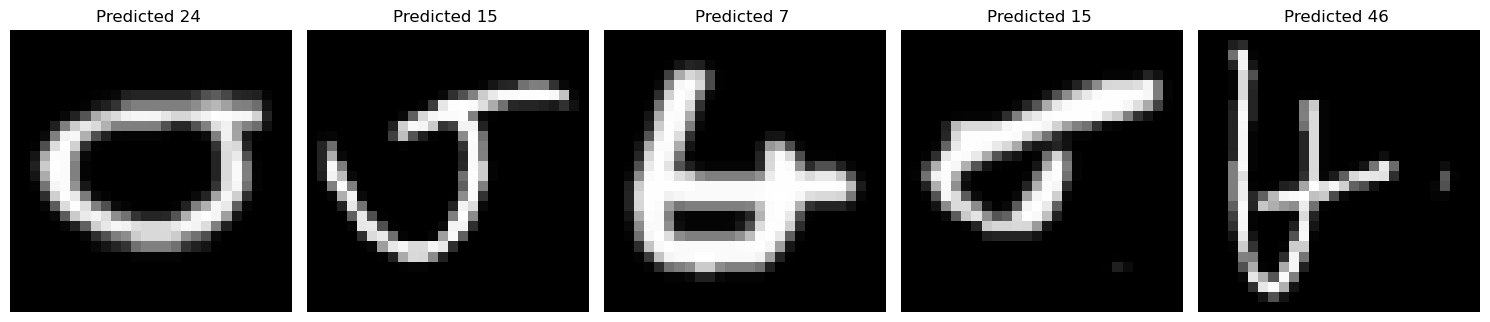

 =========== Label 26 =========== 
On device cpu.


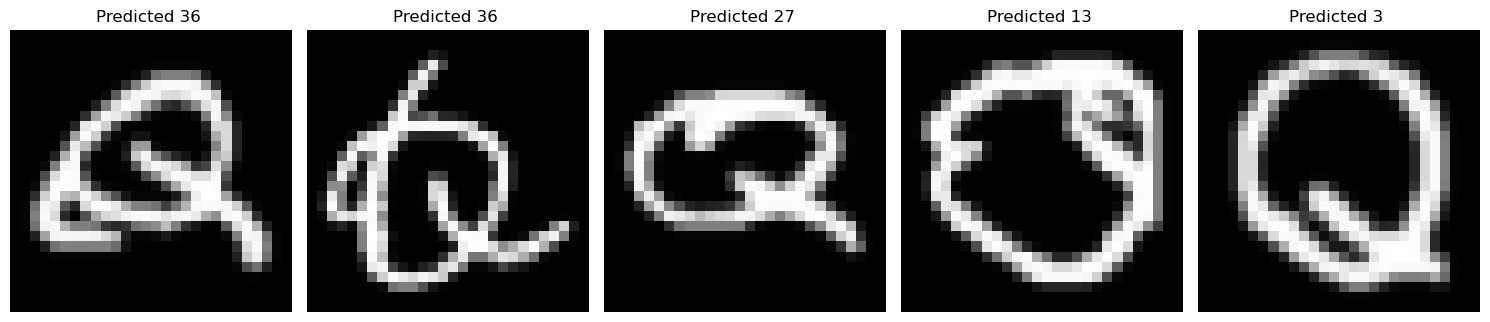

 =========== Label 27 =========== 
On device cpu.


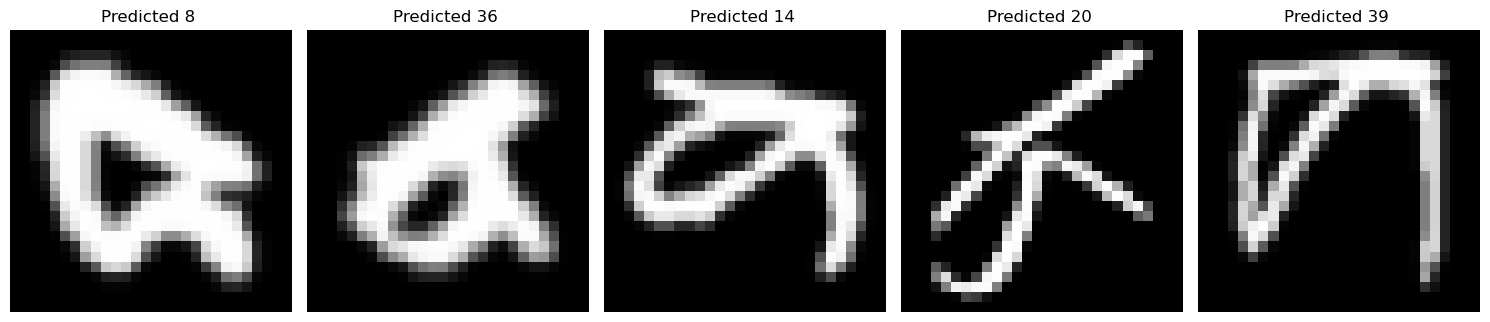

 =========== Label 28 =========== 
On device cpu.


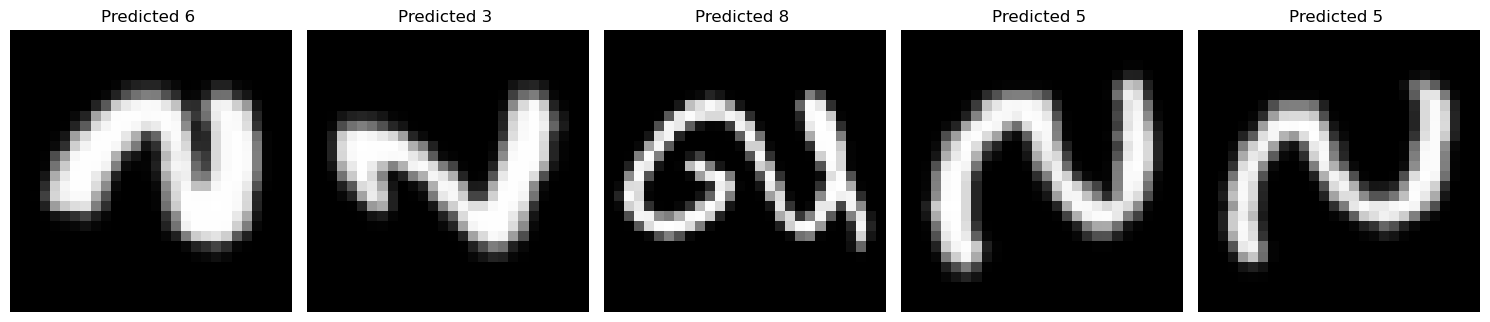

 =========== Label 29 =========== 
On device cpu.


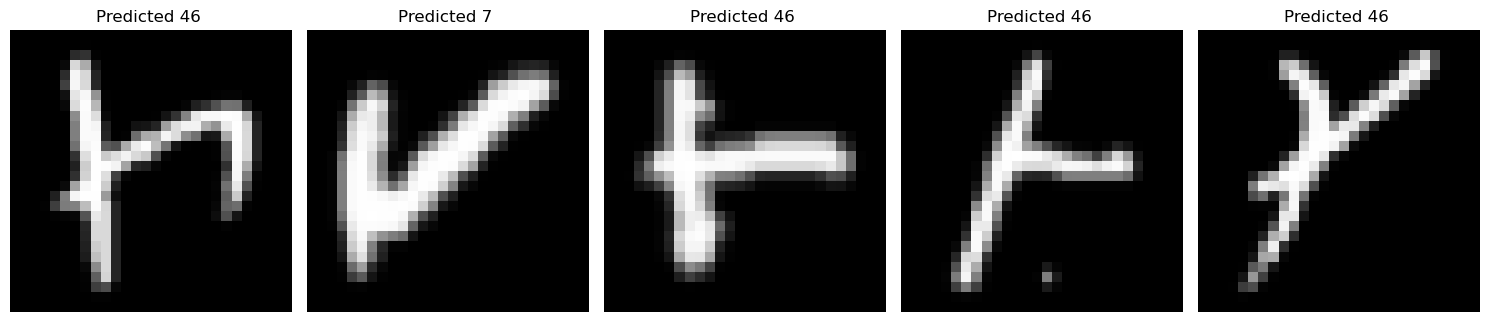

 =========== Label 30 =========== 
On device cpu.


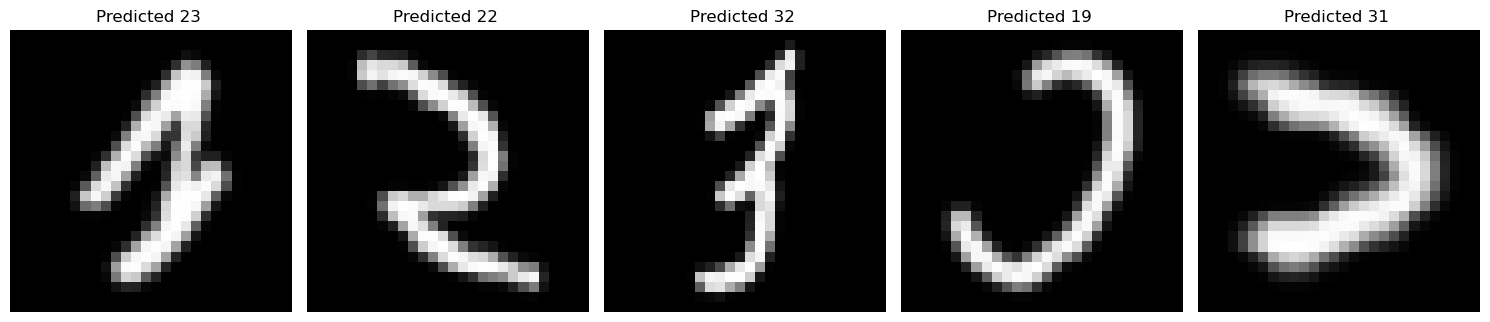

 =========== Label 31 =========== 
On device cpu.


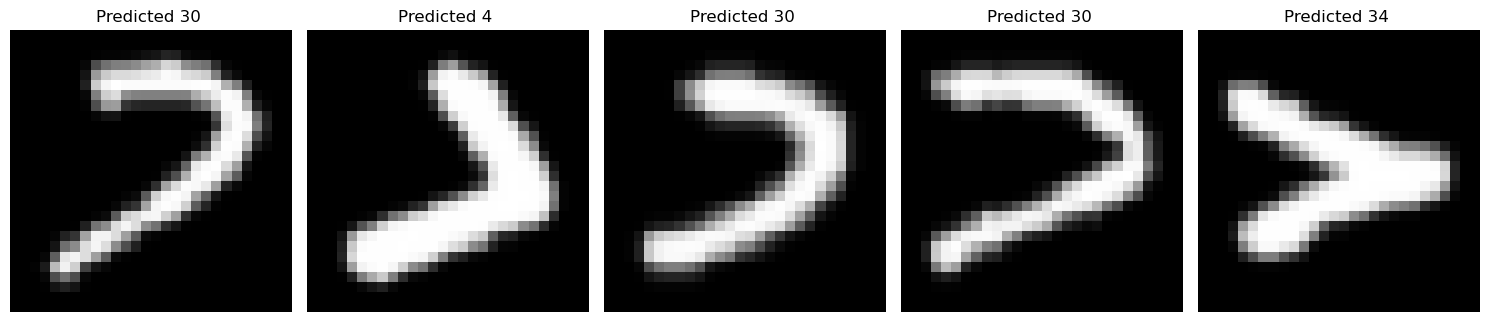

 =========== Label 32 =========== 
On device cpu.


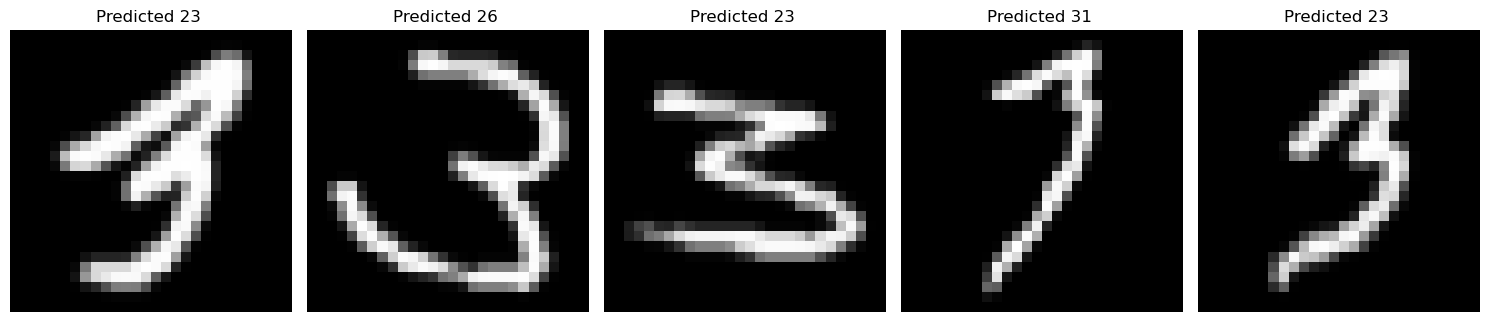

 =========== Label 33 =========== 
On device cpu.


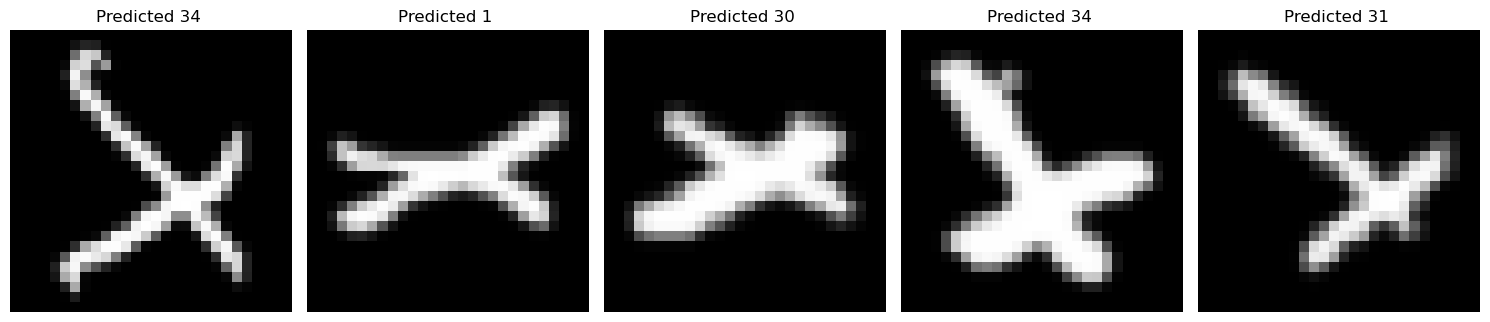

 =========== Label 34 =========== 
On device cpu.


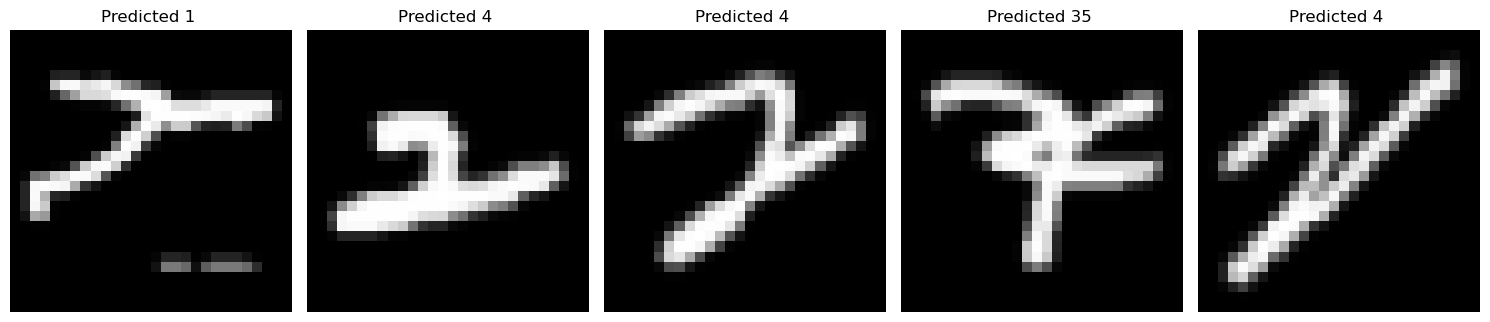

 =========== Label 35 =========== 
On device cpu.


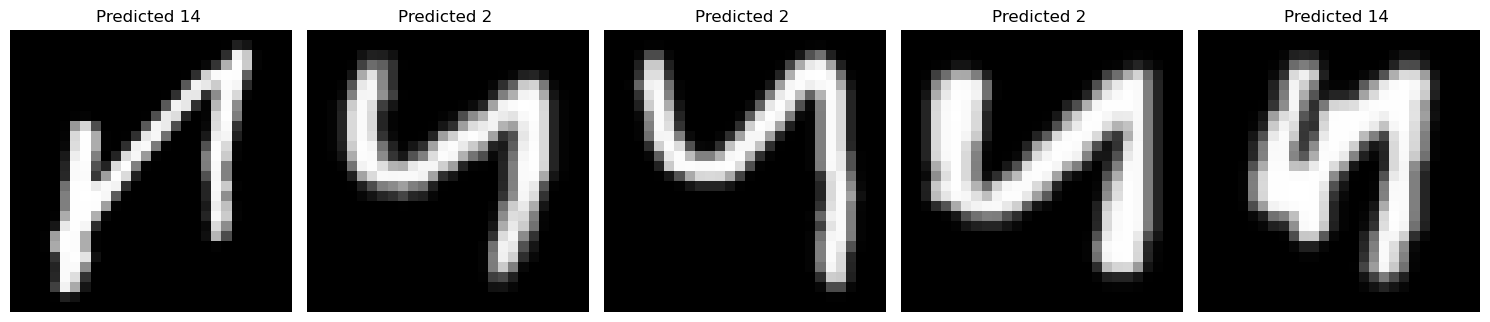

 =========== Label 36 =========== 
On device cpu.


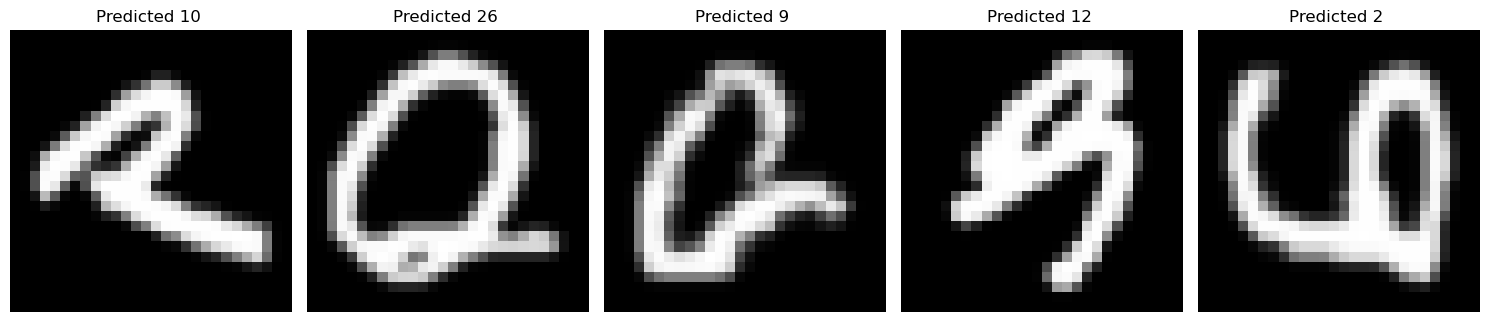

 =========== Label 37 =========== 
On device cpu.


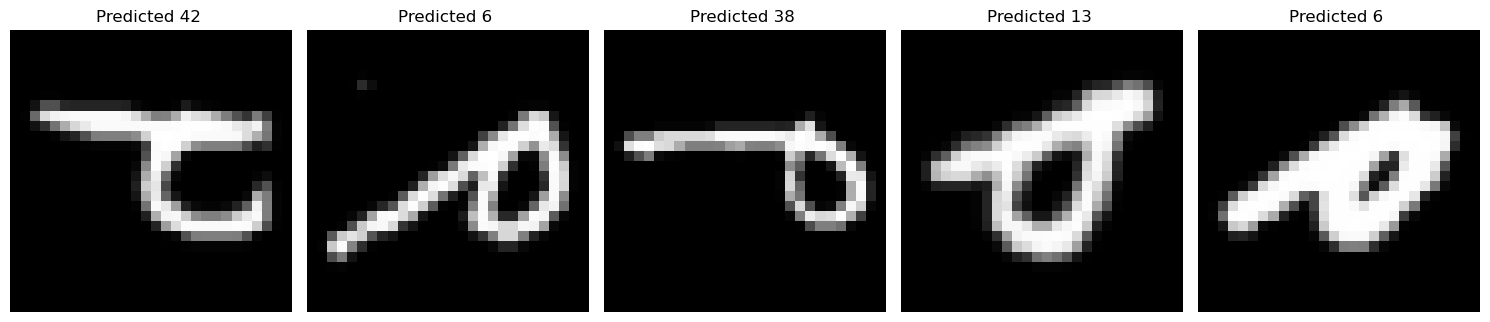

 =========== Label 38 =========== 
On device cpu.


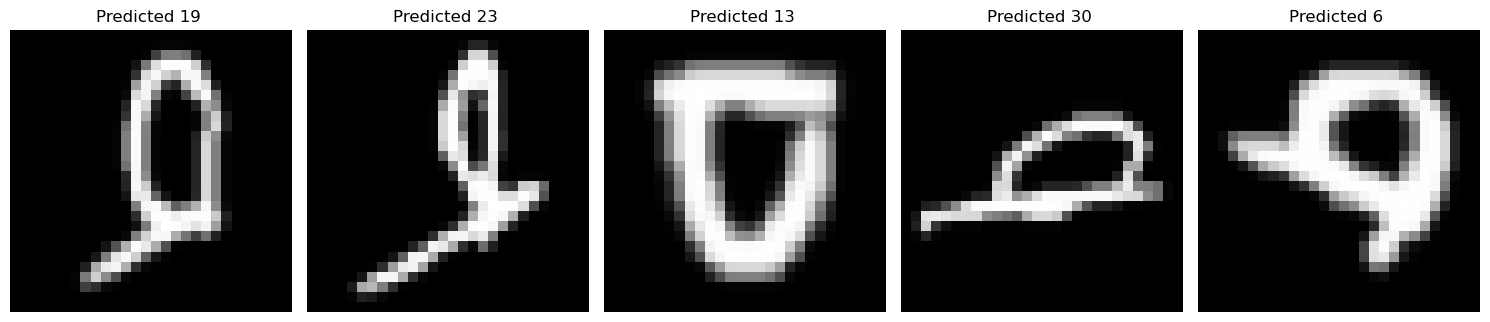

 =========== Label 39 =========== 
On device cpu.


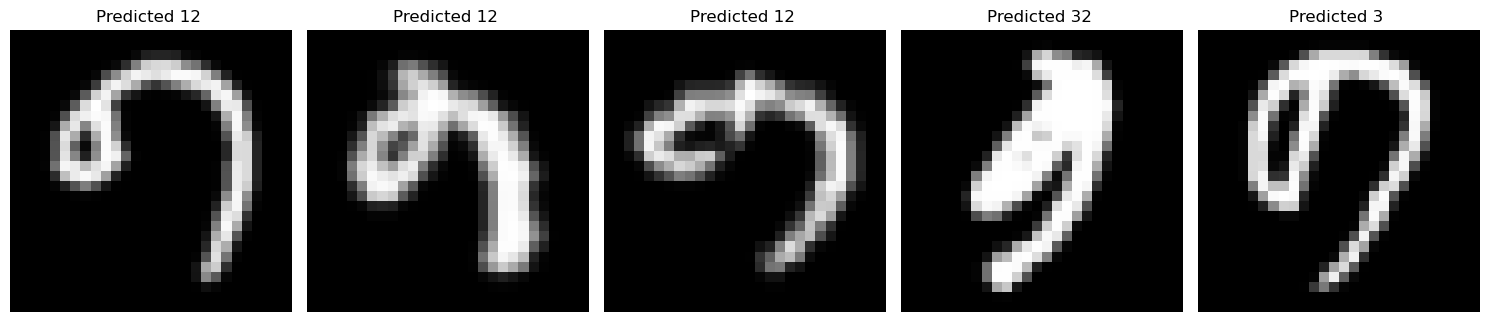

 =========== Label 40 =========== 
On device cpu.


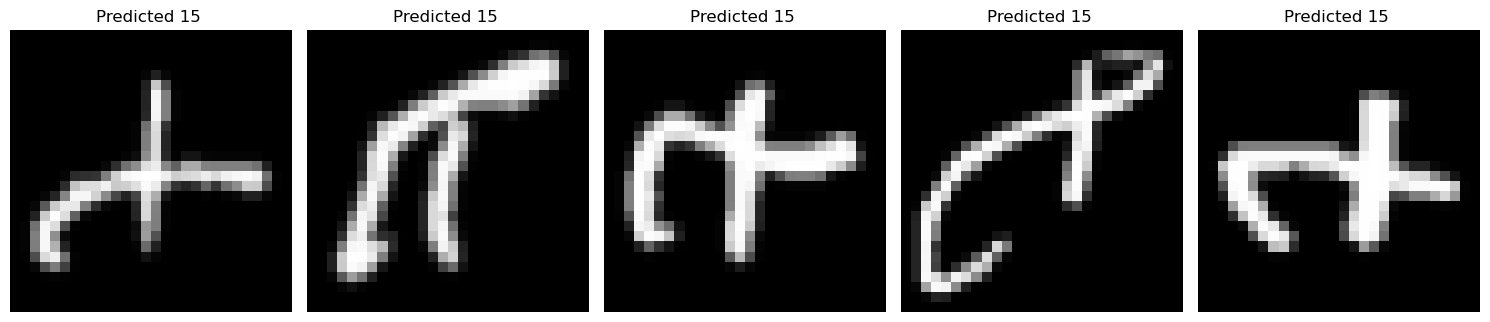

 =========== Label 41 =========== 
On device cpu.


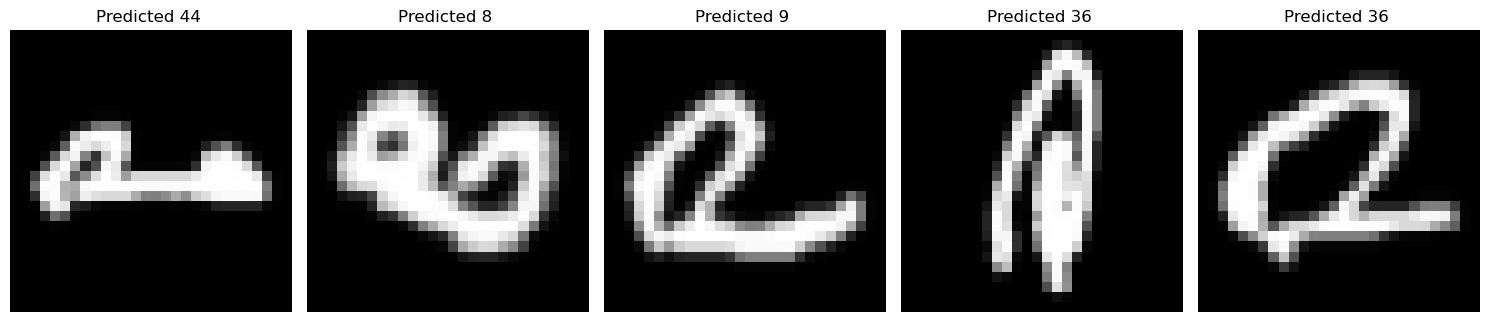

 =========== Label 42 =========== 
On device cpu.


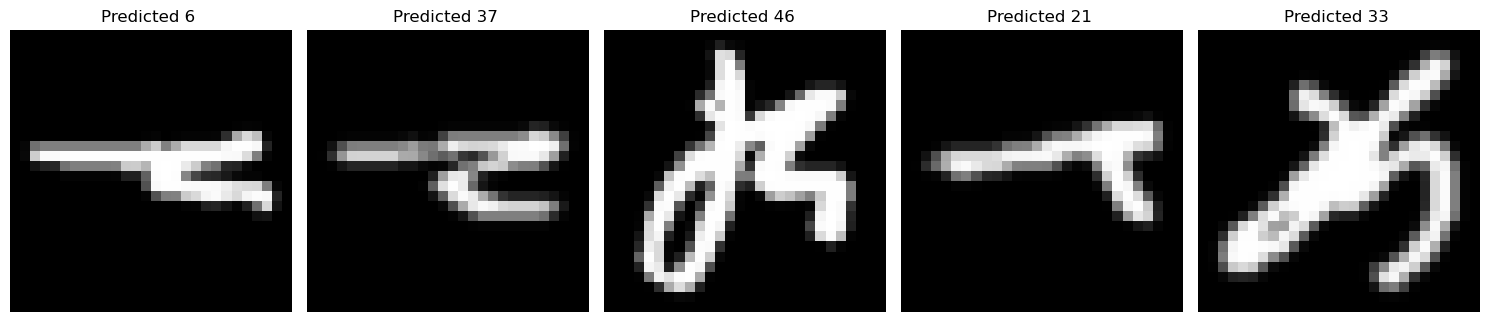

 =========== Label 43 =========== 
On device cpu.


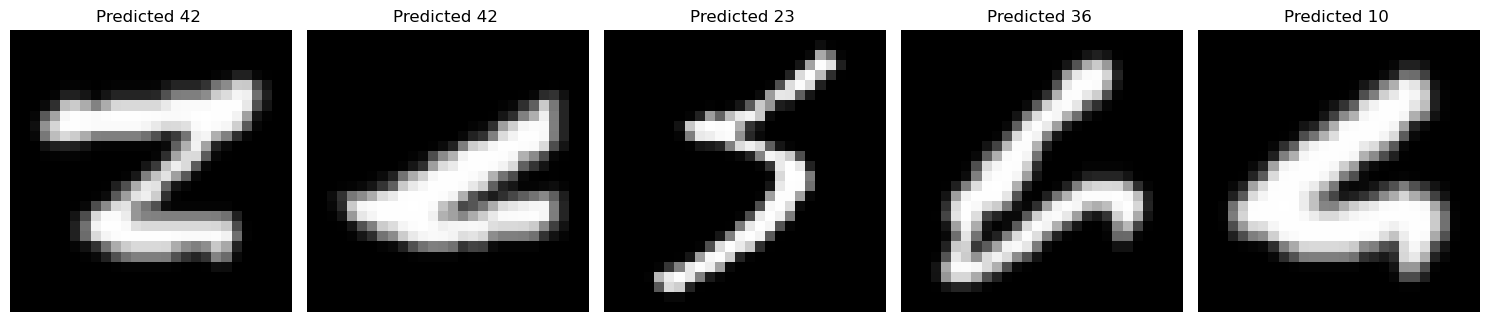

 =========== Label 44 =========== 
On device cpu.


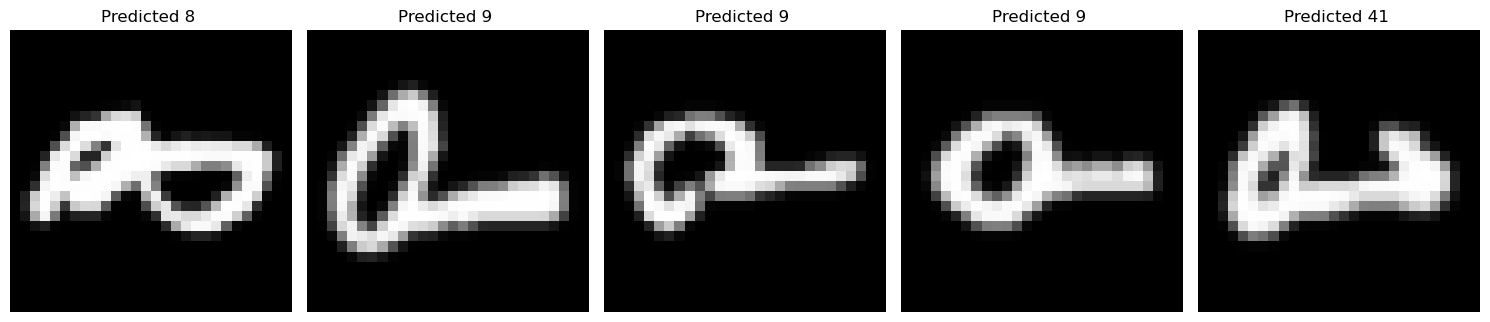

 =========== Label 45 =========== 
On device cpu.


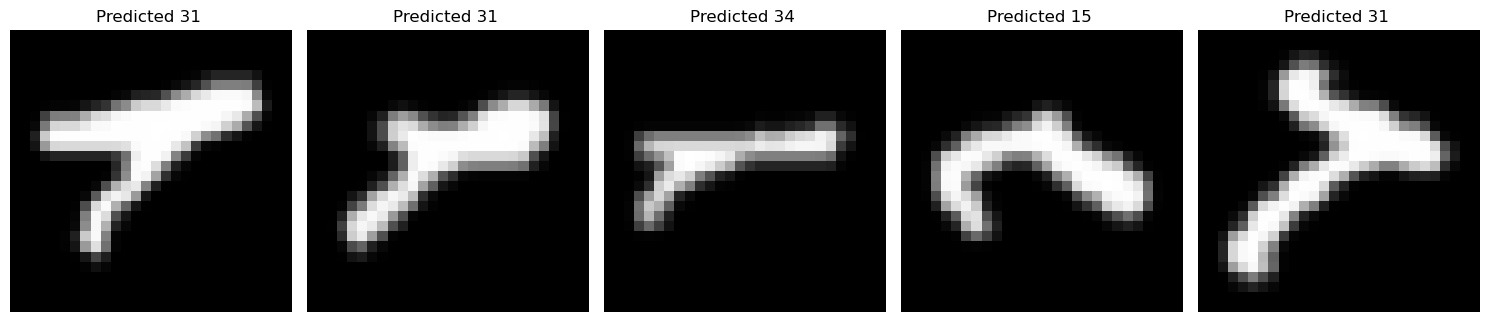

 =========== Label 46 =========== 
On device cpu.


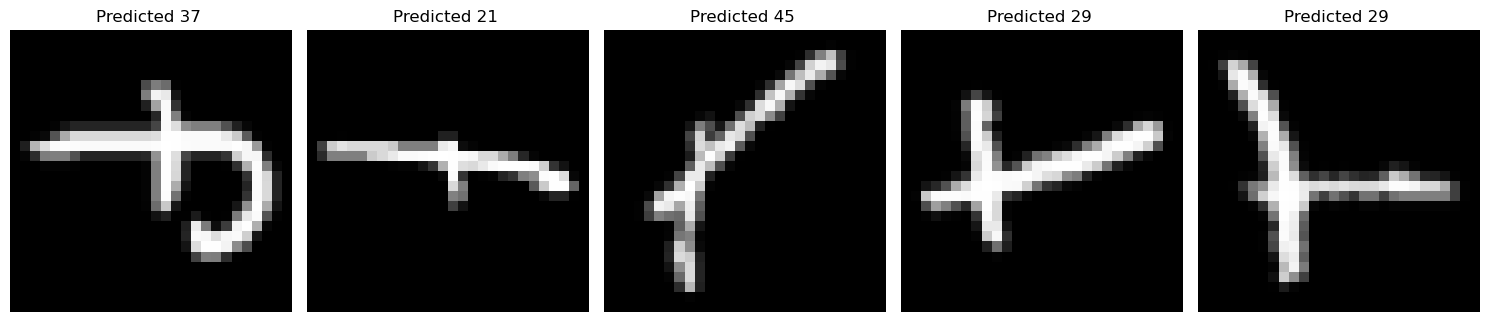

In [20]:
# Number of examples kept per label
n_keep = 5

# Plot examples of misclassified images for each label
for i in range(n_classes):
    print(" =========== Label %d =========== " %i)
    fig, axes = plt.subplots(nrows=1, ncols=n_keep, tight_layout=True, figsize=(15,5))
    kept_imgs, kept_labels, kept_preds = find_examples_inputs(best_model, test_loader, label=i)
    for j, ax in enumerate(axes.flat):
        ax.imshow(kept_imgs[j].cpu().permute(1, 2, 0), cmap='gray')
        ax.axis('off')
        ax.set_title("Predicted %d " %(kept_preds[j]))
    plt.show()

### 3.3 Final comments

#### Tasks

1. In which cases does your selected model seem to struggle? In which cases does your model seem to yield good results? How would you explain that?
1. If you were given unlimited time, what would you try to improve your performance?